# Notebook content overview

This notebook contains both my first exploration of teh CAVE client api to access teh connectomics data, together with the porcess through which I have extracted the connectome for the funnctionally matched cells and an exploratory analysis of the data.

### Part 1: Database exploration

In this section I have explored the different tables available in the minnie65 v343 release of the connectomics data, summarising the content of each table and familiarising myself with teh functions available as part of CAVEclient to acces the various tables and to query/manipulate this data.

### Part 2: Data manipulationa nd extraction

**Importing Tables**: 
In this section I have queryed and defined as local variables a series of useful tables from the minnie65 v343 release. In particular I have also imported a file showing excitatory/innhibitory information for neurons in the v117 release and have printed some descriptive information on the proportion of cells classified as nenurons according to the different models used in each table.
    
    NOTE: Here I have saved locally the information on functionally matched cells (**functional_coreg.csv**) and the fully pooofread funnctionally matched neurons (**proofreading_status_public_release.csv**)

**Extracting Connectomic Data**: 
In this section I first define some functions which allow me to extract the pre-synaptic network of a specified prost synaptic neuron. I then move on to extracting the connectome that exists amongst those cells that have been functionally matched (this for which we knwo their neural repsonse to shown stimuli). Thus for each of the functionally matched cells I have all of their pre-synaptic connections coming form nneurons that are also functionally matched.
    
    NOTE: This information is then saved locally in a file called **funnctional_connectome.csv** (to note that saving this connectome was doen in stages so here I also saved locally 8 pieces of teh connectome (** data_p1..8.csv**) that I then re imported and joined in a single file).

I then prooceed to extract a generalised connectome (not limited to functionally matched nneurons) for a sample of fully proofread and non-fully proofread neurons. These will be important for the exploratory analysis section that is present after.

    NOTE: This data is saved locally in files named **post_neuron_id_0.csv** if non-fully proofread and **post_neuron_id_1.csv** if fully proofread

Finally this section concludes with some code to generate a 3d visualisation of any neuron in the neuroglancer web app.

### Part 3: Exploratory Analysis

In this section I have carried out some initial exploratory analysis on the features of the samples of functinally matched and non functionally matched cells. For each of the two samples (functionally matched and non functionally matched) I generate useful visualisations to explore:

    1. Proportion of neurones that are within and outside the cubic millimiter of data (for each neuron in the sample and over the whole sample)
    2. Distribution of synaptic cleft sizes (for each neuron in the sample and over the whole sample)
    3. Proportion of functionally matched neurones amongst pre-synaptic cells (for each neuron in the sample and over the whole sample)
    4. Proportion of excitatory and inhibitory neurones (for each neuron in the sample and over the whole sample)

I then move to carry out some more general exploratory analysis over the whole dataset to understand how many cells are functionally matched, how many are proof read...
In addition I check the dustribution of synaptic celft size for for inhibitory and excitatory neurons depedning on whether they ar efully prooofread or not, and do the same for teh distribution of tehir connection counts.

Finally I visualise the number of connections that are of unknown origin amongst teh fully proofread cells.


# Imports

In [1]:
from caveclient import CAVEclient
import nglui
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx
import pcg_skel


In [2]:
client = CAVEclient('minnie65_public_v343')


# Database Exploration

## Exploring the tables

In [298]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

- **'synapses_pni_2'**: Table containing all 300 million+ synaptic connections between the cells (maximum 500000 per query)

- **'nucleus_neuron_svm'**: Table highlighting if cell is or not a neurone based on an SVM model for 171815 cells

- **'nucleus_detection_v0'**: Table identifying nuclei and their volume for 144120 cells

- **'functional_coreg'**: Table of the 9518 cells that have been matched with the functional data as per NEW version 343

- **'func_unit_em_match_release'**: Table of the 200 cells that have been matched with the functional data as per the OLD version 117.

- **'proofreading_status_public_release'**: Table containing the 764 neuornes that have been manually and fully proofread for things such as following an axon and removing false merges.

- **'allen_v1_column_types_slanted'**: table containing information on whether neurone is excitatory or inhibitory for 1364 cells (so in a smaller region), an adapttation of earlier allen_v1_column_types_v2 table. These are the manually labbeled cells that come from the earlier manual calssification effort. These thus reflect human categories and labels.

- **'aibs_column_nonneuronal'**: Table classifying the typing of the non-neuronal cells in the same region as allen_v1_column_types_slanted table.

- **'aibs_soma_nuc_metamodel_preds_v117'**: Table containing classification informatio in neurone or not neurone for 86916 cells in the dataset (it will update foreign key when nucleus_detection_v0 is updated). This is a metamodel incorporating all best models acros the segmentation hierarchy. It has information on less cells than for example *nucleus_neurone_svm* since it also includes a Quality Control (QC) criteria that excludes nuclei with too low quality features for the model to provide accurate results.

In [27]:
client.materialize.get_table_metadata('proofreading_status_public_release')

{'table_name': 'proofreading_status_public_release__minnie3_v1',
 'created': '2021-06-28T23:51:29.394068',
 'id': 8219,
 'valid': True,
 'aligned_volume': 'minnie65_phase3',
 'schema': 'compartment_proofread_status',
 'schema_type': 'compartment_proofread_status',
 'user_id': '56',
 'description': "The proofreading status of neurons that have been comprehensively proofread within this version. Axon and dendrite compartment status are marked separately under 'axon_status' and 'dendrite_status', as proofreading effort was applied differently to the different compartments in some cells. There are three possible status values for each compartment: 'non' indicates no comprehensive proofreading. 'clean' indicates that all false merges have been removed, but all tips have not necessarily been followed. 'extended' indicates that the cell is both clean and all tips have been followed as far as a proofreader was able to. The 'pt_position' is at a cell body or similar core position for the cell. 

In [231]:
client.materialize.get_table_metadata('synapses_pni_2')

{'created': '2020-11-04T06:48:36.953637',
 'schema': 'synapse',
 'valid': True,
 'table_name': 'synapses_pni_2__minnie3_v1',
 'aligned_volume': 'minnie65_phase3',
 'id': 8213,
 'schema_type': 'synapse',
 'user_id': '304',
 'description': 'Automated synapse detection performed by Nick Turner from the Seung Lab.  size represents the number of (4x4x40 nm) voxels painted by the automated cleft segmentation, and the IDs reference the IDs of the cleft segmentation.  Ctr_pt reflects the centroid of the cleft segmentation. The cleft segmentation volume is located in the flat_segmentation_source field. ',
 'notice_text': None,
 'reference_table': None,
 'flat_segmentation_source': 'precomputed://s3://bossdb-open-data/iarpa_microns/minnie/minnie65/clefts-sharded/',
 'write_permission': 'PRIVATE',
 'read_permission': 'PUBLIC',
 'last_modified': '2022-10-25T19:24:28.559914',
 'segmentation_source': '',
 'pcg_table_name': 'minnie3_v1',
 'last_updated': '2023-02-27T08:10:01.173745',
 'annotation_tab

In [85]:
# This table gives us information on neurone type (excitatory and not and cell type)
# it containes ONLY neurones (equivalent tabel for non neurones is aibs_column_nonneuronal)
n_type = client.materialize.query_table('allen_v1_column_types_slanted')
print(f"Neuorn types: {set(n_type['classification_system'])}")
print(f'Shape: {n_type.shape}')
n_type.head(2)

Neuorn types: {'aibs_coarse_inhibitory', 'aibs_coarse_excitatory', 'aibs_coarse_unclear'}
Shape: (1364, 7)


,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,1379,t,aibs_coarse_excitatory,4P,89242892866409455,864691135687112672,"[178160, 175136, 21428]"
1,1382,t,aibs_coarse_excitatory,5P-IT,89594805373727621,864691135162584621,"[180624, 175696, 21782]"


In [88]:
# Neurones that have been manually proofread
proofread_n = client.materialize.query_table('proofreading_status_public_release')
print(f'Shape: {proofread_n.shape}')
proofread_n.head(2)

Shape: (764, 8)


,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[191424, 209888, 22845]"
1,7,t,91570559116360958,864691136602027473,864691136602027473,extended,non,"[194864, 216128, 22205]"


In [90]:
#Neurones automatically matched using the ML model developed by Allen institute
neurones = client.materialize.query_table('nucleus_neuron_svm')
print(f"Cell types: {set(neurones['cell_type'])}")
neurones = neurones[neurones['cell_type'] == 'neuron']
print(f'Shape: {neurones.shape}')
neurones.head(2)

Table Owner Warning: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


Cell types: {'not-neuron', 'neuron'}
Shape: (89062, 7)


,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
87,1841,t,is_neuron,neuron,0,0,"[57536, 105584, 19883]"
92,1896,t,is_neuron,neuron,0,0,"[59872, 96608, 19853]"


## Familiarising with function and data in a general way

In [3]:
#calling a table and visualising its content
func_matched = client.materialize.query_table('functional_coreg')
func_matched.head()

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
0,1,t,102531727972419182,864691136136642173,4,7,665,"[274864, 94064, 22046]"
1,2,t,94792540099826672,864691136208993724,4,7,740,"[218320, 104320, 19016]"
2,4,t,93946810036875732,864691135683934135,4,7,782,"[212128, 94544, 23423]"
3,5,t,84730565597057981,864691135334528233,4,7,855,"[145158, 110036, 19355]"
4,6,t,110905058841147285,864691136309730650,4,7,921,"[335744, 90128, 22805]"


In [4]:
func_matched.shape

(9518, 8)

In [61]:
#Selecting a specific cell id
seg_id = 864691135771728459
#Using teh apporpriate function to query all the pre-synaptic connectionsn of the specified cells
input_df = client.materialize.synapse_query(post_ids=seg_id)
input_df.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,418256326,t,110554588637090037,864691136225847998,110554588637094803,864691135771728459,2076,"[333188, 100100, 15887]","[333168, 100078, 15892]","[333152, 100122, 15887]"
1,430716388,t,111541950213409899,864691136014082483,111541950213405321,864691135771728459,7740,"[340510, 116586, 17207]","[340480, 116550, 17203]","[340470, 116562, 17207]"
2,423627274,t,110835994894437844,864691135469469354,110835994894432901,864691135771728459,1580,"[335280, 99848, 15983]","[335310, 99824, 15976]","[335338, 99859, 15985]"
3,420798973,t,110626675569901342,864691136692383997,110626606850394201,864691135771728459,7192,"[333514, 112862, 17777]","[333630, 112836, 17777]","[333588, 112850, 17775]"
4,440276549,t,112174375557671350,864691134175939595,112174375557660657,864691135771728459,2064,"[344984, 109974, 17109]","[344958, 109834, 17098]","[344963, 109899, 17107]"


In [62]:
input_df.shape

(4919, 10)

In [63]:
#Aggregating by pre synaptic cell, getting mean synaptic clef size and count of how many connections
#are present with the same pre-synaptic cell
pre_neur = input_df.groupby('pre_pt_root_id').agg({'size':'mean', 'valid':'count'})
pre_neur = pd.DataFrame(pre_neur).reset_index()
pre_neur = pre_neur.rename(columns = {'valid':'count'})

In [64]:
pre_neur

,pre_pt_root_id,size,count
0,864691131922339478,4304.0,1
1,864691131937381100,1920.0,1
2,864691131957395800,3588.0,1
3,864691131982184389,4692.0,1
4,864691132047706369,3236.0,1
...,...,...,...
4530,864691136954473537,4132.0,1
4531,864691136955062337,4532.0,1
4532,864691136955090753,12360.0,1
4533,864691136965768654,260.0,1


In [65]:
# Adding a column to unnderstand how many pre synaptic cells for the selected post synaptic cells
#have been functionally matched
#List to store information
fun_m = []
#Iterating through unique pre synapti cell ids and checkin if in functionally matched set
for i in pre_neur['pre_pt_root_id']:
    if i in set(func_matched['pt_root_id']):
        fun_m.append(1)
    else:
        fun_m.append(0)
pre_neur['functional_data_matched'] = fun_m

In [66]:
pre_neur[pre_neur['functional_data_matched']!=0]

,pre_pt_root_id,size,count,functional_data_matched
1599,864691135181759234,11728.0,1,1
1769,864691135341014469,1982.0,2,1
1820,864691135393979637,1440.0,1,1
2180,864691135539037938,1952.0,1,1
2506,864691135609594119,2228.0,1,1
3460,864691135855890478,2980.0,1,1
3512,864691135918336176,5804.0,1,1
3565,864691135946666593,7844.0,1,1
3721,864691136031708859,3768.0,1,1
3732,864691136105702361,2948.0,2,1


# Data manipulation and extraction

## Importing tables

In [4]:
#Importing table of functionally matched cells
funct_match = client.materialize.query_table('functional_coreg')

#Saving it locally
#funct_match.to_csv('functional_coreg.csv')

In [26]:
funct_match.shape

(9518, 8)

In [7]:
funct_match.head()

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
0,1,t,102531727972419182,864691136136642173,4,7,665,"[274864, 94064, 22046]"
1,2,t,94792540099826672,864691136208993724,4,7,740,"[218320, 104320, 19016]"
2,4,t,93946810036875732,864691135683934135,4,7,782,"[212128, 94544, 23423]"
3,5,t,84730565597057981,864691135334528233,4,7,855,"[145158, 110036, 19355]"
4,6,t,110905058841147285,864691136309730650,4,7,921,"[335744, 90128, 22805]"


In [8]:
#Identifying all the pairs of (session, scan_idx) present amongst these cells
pairs = []
for s, sc in zip(funct_match['session'], funct_match['scan_idx']):
    pairs.append((s, sc))

set(pairs)

In [5]:
#Querying the table containing teh fully proof read functionally matched neurons
full_proof = client.materialize.query_table('proofreading_status_public_release')

#Saving it locally
#full_proof.to_csv('proofreading_status_public_release.csv')

In [ ]:
full_proof.head()

In [ ]:
print(f"Number of fully proofread cells: {full_proof.shape[0]}\nNumber of fully proofread cells fully followed: {full_proof[(full_proof['status_dendrite'] == 'extended')& (full_proof['status_axon'] == 'extended')].shape[0]}")

In [7]:
#Loading a locally saved version of a table from minnie 65 v117 containing information on whether a neuron is
#excitatory or inhibitory
ex_in = pd.read_csv('../Data/allen_soma_ei_class_model_v1.csv')

In [ ]:
ex_in.head()

In [8]:
#Querying table with manually classified neurons in excitatory and inhibitory classes
manual = client.materialize.query_table('allen_v1_column_types_slanted')
manual.shape

(1364, 7)

In [9]:
#Querying tables containing different model results calssifiying cells as neurons or nnot neurons
svm = client.materialize.query_table('nucleus_neuron_svm')
metamodel = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
nuc = client.materialize.query_table('nucleus_detection_v0')

#Below we show some descriptives on the nnumber of cells identified as neurons by each model

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Suffixes is deprecated for complex queries as it can be ambiguous what you desire, please pass suffix_map as a dictionary to explicitly set suffixes for individual tables. Upgrade caveclient to >=5.0.0


In [142]:
print(f"Svm cell numbers: {svm.shape[0]}\nMetamodel cell numbers:{metamodel.shape[0]}")

Svm cell numbers: 171815
Metamodel cell numbers:86916


In [145]:
print(f"Svm NEURON numbers: {svm[(svm['pt_root_id']!=0) & (svm['cell_type']=='neuron')].shape[0]}\nMetamodel NEURON numbers:{metamodel[metamodel['classification_system'] =='aibs_neuronal'].shape[0]}")

Svm NEURON numbers: 82247
Metamodel NEURON numbers:67725


Note the nucleus ids in the 'proofreading_status_public_release' and 'functional_coreg' table do not match and thus you need to use the root_id to match on those

## Extracting Connectomic data

### Defining functions

In [19]:
def pre_neurones_matcher(root_id):
    '''This function extracts the presynaptic connections for a given post synaptic cell specified by its root id.
    In particular for each pre synaptic connection it will also specify whether:
    1. it is functinally matched
    2. if it is excitatory or inhibitory
    3. if it is in the mm_cube of the brain mapped by the MICrONS team or if it belongs outside of it and only extends in to it
    4. the volume of the synaptic cleft between the post synaptic and pre synaptic neurons (returns average if more than one connection between the two)
    5. the number of connections between the post synaptic neuron and the specific pre synaptic one
    
    Parameters:
    root_id: root_id identifying the post synaptic neuron for whcih to exrtact the pre-synaptic connections
    
    Returns:
    pre_neur: a DataFrame with the sepcified pre synaptic connections annd informations'''
    
    #generate df with matches to functional data
    func_matched = client.materialize.query_table('functional_coreg')

    #generate df with information on neurones in cubic mm
    svm = client.materialize.query_table('nucleus_neuron_svm')

    #generate df with pre-synaptic neurones for selected neurone
    input_df = client.materialize.synapse_query(post_ids = root_id)
    #read in df with excitatory/inhibitory information
    ex_in = pd.read_csv('/Users/jacopobiggiogera/Desktop/MSc Bocconi materials/Dissertation/Data/allen_soma_ei_class_model_v1.csv')
    #reding in df with the manual effort cells
    manual = client.materialize.query_table('allen_v1_column_types_slanted')

    #group by single pre-synaptic neurone
    pre_neur = input_df.groupby('pre_pt_root_id').agg({'size':'mean', 'valid':'count'})
    pre_neur = pd.DataFrame(pre_neur).reset_index()
    pre_neur = pre_neur.rename(columns = {'valid':'count'})

    fun_m = []#saving if each pre synaptic neurone matches to functional data (where 1: matched, 0: not matched)
    e_i = [] #saving if excitatory/inhibitory
    in_mmcube = [] #saving if neurone in mm_cube of data
    for i in pre_neur['pre_pt_root_id']:

        #adding information on whether neurone has been functionally matched
        if i in set(func_matched['pt_root_id']):
            fun_m.append(1)
        else:
            fun_m.append(0)

        
        #adding information on whether it is excitatory or inhibiroty
        nuc_id = svm[svm['pt_root_id'] == i]['id']
        if len(nuc_id) ==0:
            if i == 0:
                in_mmcube.append('out')
                if i in set(func_matched['pt_root_id']):
                    e_i.append('excitatory')
                elif i in set(manual['pt_root_id']):
                    e_i.append(manual[manual['pt_root_id']==i]['classification_system'].iloc[0].split('_')[-1])
                else:
                    e_i.append('NaN')
                continue
            else:
                in_mmcube.append('unknown')
                if i in set(func_matched['pt_root_id']):
                    e_i.append('excitatory')
                elif i in set(manual['pt_root_id']):
                    e_i.append(manual[manual['pt_root_id']==i]['classification_system'].iloc[0].split('_')[-1])
                else:
                    e_i.append('NaN')
                continue
        else:
            in_mmcube.append('in')
            nuc_id = nuc_id.iloc[0,]
        c_t = ex_in[ex_in['id'] ==nuc_id]['cell_type']
        if len(c_t)!=0:
            e_i.append(c_t.iloc[0,])
        else:
            #accounting for the fact that if it has been functionally matched it is excitatory by default
            if i in set(func_matched['pt_root_id']):
                e_i.append('excitatory')
            elif i in set(manual['pt_root_id']):
                e_i.append(manual[manual['pt_root_id']==i]['classification_system'].iloc[0].split('_')[-1])
            elif i in set(svm[svm['cell_type']=='not-neuron']['pt_root_id']):
                e_i.append('not-neuron')
            else:
                e_i.append('NaN')
        

    pre_neur['functional_data_matched'] = fun_m
    pre_neur['neuron_type'] = e_i
    pre_neur['in_mmcube'] = in_mmcube
    return pre_neur
    

In [20]:
def func_pre_subsetter(to_keep, func_id):
    '''This is a function to return all of the pre_synaptic neurons that are functionally matched for a given 
    neuron id passed as func_id

    Parameters: 
    to_keep: set of root ids of functionally matched neurons that we wish to subset synapse df of func_id by
    func_id: root_id of neuorn for which we want to extract pre synaptic connections.

    Returns: df containing connections between func_id neuron and all its functionally matched pre synaptic neurons'''

    syn = client.materialize.synapse_query(post_ids=func_id)
    sub = syn[syn['pre_pt_root_id'].isin(to_keep)].loc[:, ['post_pt_root_id', 'pre_pt_root_id', 'size','post_pt_position', 'pre_pt_position']]
    return sub

### Extracting pre-synpatic connections for functionally matched neurones

In [12]:
#Extracting all the root id of the functionally matched cells
fun = set(funct_match[funct_match['pt_root_id'] != 0]['pt_root_id'])
len(fun)

8857

In [14]:
#Generating the dataframe of pre synaptic connections for all functionally matched cell
df = func_pre_subsetter(fun, 864691135181717506)

#Removing cells with faulty match (root_id = 0) and the one we have already extracted from set of cells still to extract
prel = list(set(funct_match[(funct_match['pt_root_id'] != 0)&(funct_match['pt_root_id'] != 864691135181717506)]['pt_root_id']))

#Iterate through the cells
for i in prel[6482:]:
    #extract pre-synaptic connectome for the cell
    s= func_pre_subsetter(fun, i)
    #Concatenate it to the one already extracted
    df = pd.concat([df,s])

Due to API limitations I had to extract the full connectome in several steps, these are the splits:

1. from cell [0, 562)
2. from cell [562, 562+1620)
3. from [562+1620,  562+1620+1215)
4. from [562+1620+1215,  562+1620+1215+731)
5. from [562+1620+1215+731,   562+1620+1215+731+782)
6. from [562+1620+1215+731+782,  562+1620+1215+731+782+1048)
7. from [562+1620+1215+731+782+1048,  562+1620+1215+731+782+1048+524)
8. from [562+1620+1215+731+782+1048+524,   562+1620+1215+731+782+1048+524+2359)

In [18]:
#Reimporting the pieces of the connectome dataset
p1 = pd.read_csv('Data/functional_connectome_pieces/data_p1.csv')
p2 = pd.read_csv('Data/functional_connectome_pieces/data_p2.csv')
p3 = pd.read_csv('Data/functional_connectome_pieces/data_p3.csv')
p4 = pd.read_csv('Data/functional_connectome_pieces/data_p4.csv')
p5 = pd.read_csv('Data/functional_connectome_pieces/data_p5.csv')
p6 = pd.read_csv('Data/functional_connectome_pieces/data_p6.csv')
p7 = pd.read_csv('Data/functional_connectome_pieces/data_p7.csv')
p8 = pd.read_csv('Data/functional_connectome_pieces/data_p8.csv')

In [19]:
#Joining all of the pieces in a single connectome
tot_parts = pd.concat([p1,p2,p3,p4,p5,p6,p7,p8])
tot_clean = tot_parts.drop_duplicates()
#Saving it
#tot_clean.to_csv('functional_connectome.csv', index = False)

In [493]:
print(f"There are {tot_clean.shape[0]} synapses across {len(set(tot_clean['post_pt_root_id']))} unique post synaptic neurons")

There are 305590 synapses across 8808 unique post synaptic neurons


Some neurons were not extracted with the automated procedure above so I have attempted to re extract them and check the outputs manually to better understand why they did not appear in the conectome 

In [20]:
# Attempting to extract reminaing neurons that seemed to have been missed in initial extraction
to_do = list(set(prel).difference(set(tot_clean['post_pt_root_id'])))
td = func_pre_subsetter(fun,to_do[3])
for c in to_do[1:]:
    new = func_pre_subsetter(fun, c)
    td = pd.concat([td,new])

In [487]:
#Explore the dataframe of these neurons, its empty (the synapse query returns no results)
td

,post_pt_root_id,pre_pt_root_id,size,post_pt_position,pre_pt_position


It seems that these 49 neurons were missed since there are no pre-synaptic neurons that are functionally matched in their network


#### Saving table of functionally matched features

In [2]:
fun_features = funct_match[funct_match['pt_root_id'] != 0] # removig entries tht are zeroes
clean = fun_features.drop_duplicates('pt_root_id') #dropping duplicates on the root id
clean.to_csv('Data/clean_functional_features.csv')

#removing the ones that have no pre synaptic connections that are functionally matched
#clean[~clean['pt_root_id'].isin(to_do)]

#### Visualising

In [13]:
tot_clean = pd.read_csv('../Data/connectome_versions/functional_connectome.csv')
tot_clean.shape

(305590, 5)

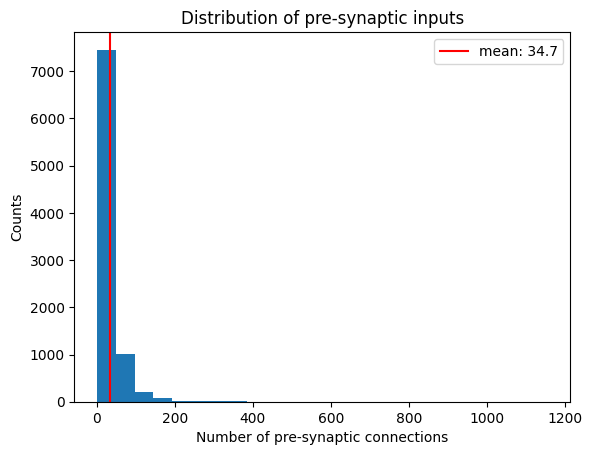

In [18]:
len(set(tot_clean['post_pt_root_id']))
dist = tot_clean.groupby('post_pt_root_id').count()['pre_pt_root_id']
plt.hist(dist, bins = 24)
plt.axvline(np.mean(dist), color = 'red', label = f'mean: {round(np.mean(dist),1)}')
plt.ylabel('Counts')
plt.xlabel('Number of pre-synaptic connections')
plt.title('Distribution of pre-synaptic inputs')
plt.legend()
plt.show()

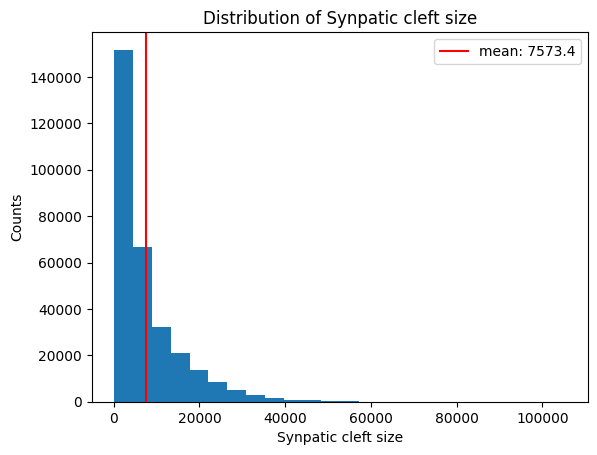

In [20]:
len(set(tot_clean['post_pt_root_id']))
conn_st = tot_clean['size']
plt.hist(conn_st, bins = 24)
plt.axvline(np.mean(conn_st), color = 'red', label = f'mean: {round(np.mean(conn_st),1)}')
plt.ylabel('Counts')
plt.xlabel('Synpatic cleft size')
plt.title('Distribution of Synpatic cleft size')
plt.legend()
plt.show()

### Extracting generalised connectome for a sample of fully and non-fully proofread neurons

In this section I used the generalised connectome generating function to generate the connectome of pre synaptic cells for a specified neuron that is not constrained by the whether the pre synaptic cell is functionally matched or not

In [ ]:
#Testing the funnction and visualising the result
t = pre_neurones_matcher(864691135991773633)
t.head()

In [250]:
#Extract the connectome for a sample fully proofread neurons
for id in [864691134988755578,864691135307251526,864691135394253301,864691135724453547, 864691137197177665]:
    n = pre_neurones_matcher(id)
    n.to_csv('sample/'f'{id}'+'_1.csv')

#Extract the connectome for a sample fo non fully proofread neurons
non_proof = set(svm['pt_root_id']).difference(set(full_proof['pt_root_id']))

for id in [864691135815455567, 864691136723411197,864691136740680284 , 864691137197177665, 864691135631799492]:
    n1 = pre_neurones_matcher(id)
    n1.to_csv('sample/'+f'{id}'+'_0.csv')

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.
Table Owner Notice on nucleus_neuron_svm: Please

### Generating neuroglancer visualisation for a specifyied neuron

Here I report some code on and comments that allow to generate a link that connects to the neurogalncer app and allows to visualise a 3d rendering of the specified neuron

In [30]:
from nglui import statebuilder

In [42]:
segment = 864691135620841539	 # get ID of segment to visualize
centroid = [210988, 161976, 23158] # get centroid of segment

In [43]:
em_layer = statebuilder.ImageLayerConfig("precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em") # public em source
seg_layer = statebuilder.SegmentationLayerConfig("precomputed://gs://iarpa_microns/minnie/minnie65/seg", name='seg', fixed_ids=[segment]) # public segmentation source
view_options = {'layout': '3d',
                'zoom_3d': 3000,
                'position': centroid} # set zoom options and center on segment

sb = statebuilder.StateBuilder([em_layer, seg_layer], view_kws=view_options)

sb.render_state(url_prefix='https://ngl.microns-explorer.org/', return_as='html')

# Exploratory Analysis

In [252]:
#Reading in data
fm1 = pd.read_csv('sample/864691134988755578_1.csv')
fm2 = pd.read_csv('sample/864691135307251526_1.csv')
fm3 =pd.read_csv('sample/864691135394253301_1.csv')
fm4 = pd.read_csv('sample/864691135724453547_1.csv')
fm5 = pd.read_csv('sample/864691137197177665_1.csv')

nfm1 = pd.read_csv('sample/864691135815455567_0.csv')
nfm2 = pd.read_csv('sample/864691136723411197_0.csv')
nfm3 = pd.read_csv('sample/864691136740680284_0.csv')
nfm4 = pd.read_csv('sample/864691137197177665_1.csv')
nfm5 = pd.read_csv('sample/864691135631799492_0.csv')


## Post synpatic neurons that have been fully proof read

In [253]:
fm1.head()

,Unnamed: 0,pre_pt_root_id,size,count,functional_data_matched,neuron_type,in_mmcube
0,0,864691131965587962,15856.0,1,0,NaN,unknown
1,1,864691131972673167,252.0,1,0,NaN,unknown
2,2,864691132115495467,8844.0,1,0,NaN,unknown
3,3,864691132241826075,2920.0,1,0,NaN,unknown
4,4,864691132253634325,15916.0,1,0,NaN,unknown


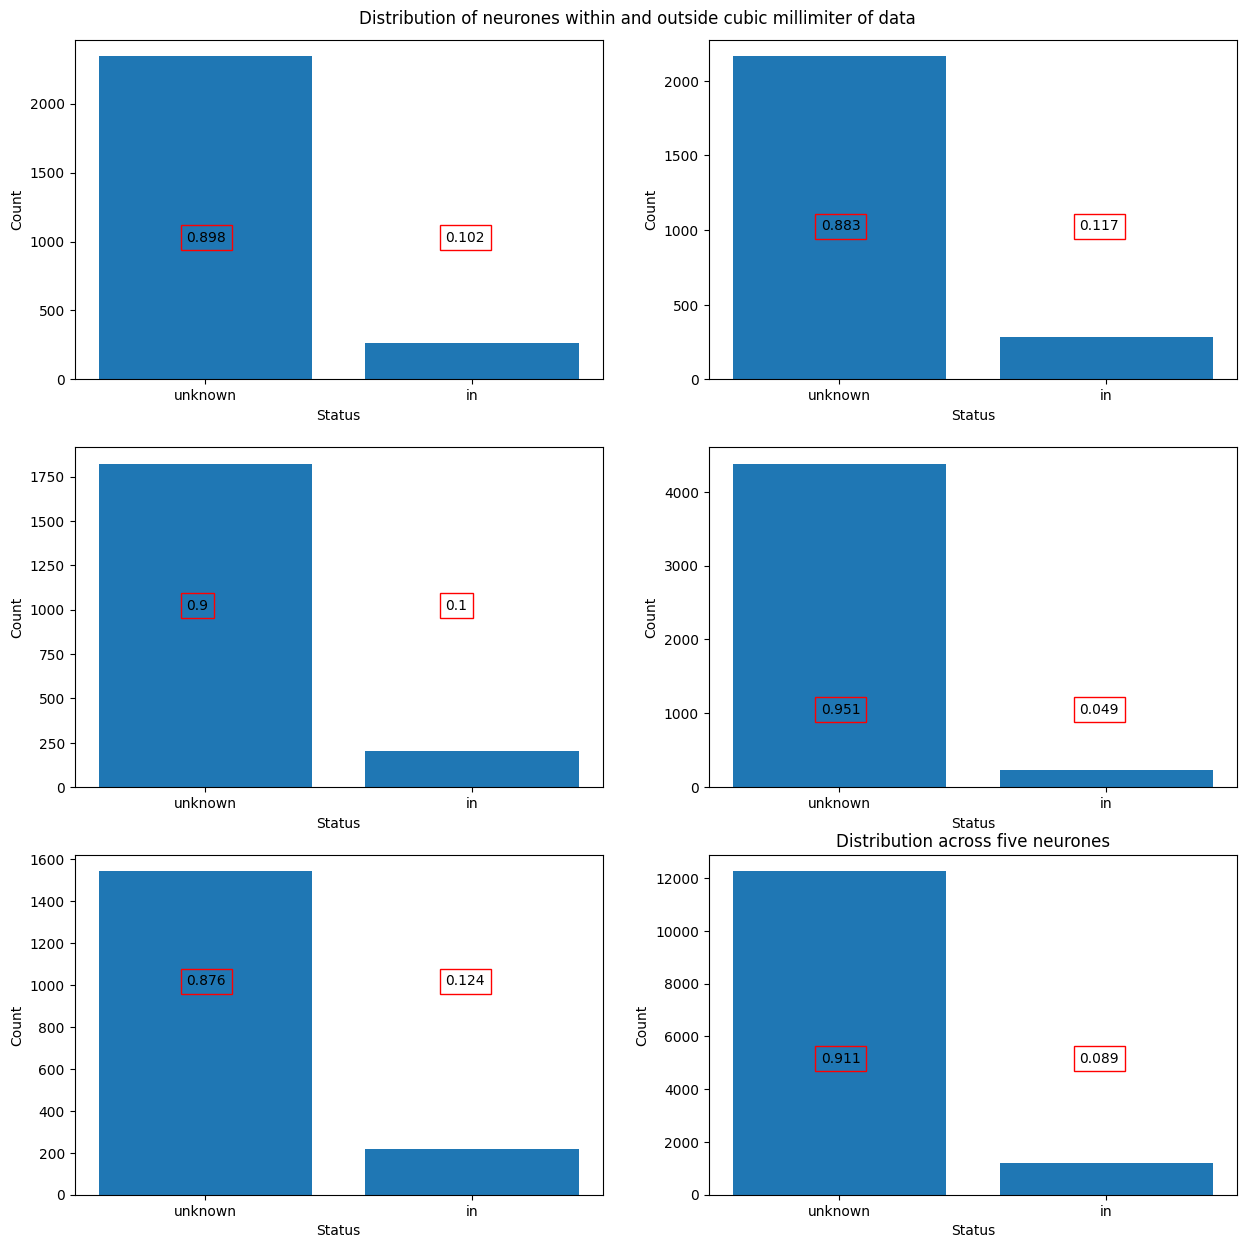

In [254]:
#Describing neurones that are withing and outside the cubic millimiter of data
from collections import Counter
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of neurones within and outside cubic millimiter of data', x = 0.5,y = 0.9)
ax = axs.ravel()
c1 = Counter(fm1['in_mmcube'].astype('str'))
c2 = Counter(fm2['in_mmcube'].astype('str'))
c3 = Counter(fm3['in_mmcube'].astype('str'))
c4 = Counter(fm4['in_mmcube'].astype('str'))
c5 = Counter(fm5['in_mmcube'].astype('str'))
cumulative = Counter(list(fm1['in_mmcube'].astype('str'))+list(fm2['in_mmcube'].astype('str'))+list(fm3['in_mmcube'].astype('str'))+list(fm4['in_mmcube'].astype('str'))+list(fm5['in_mmcube'].astype('str')))
ax[0].bar(list(c1.keys()),list(c1.values()))
ax[0].text(-0.07,1000,round(list(c1.values())[0]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(0.9,1000,round(list(c1.values())[1]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[1].bar(list(c2.keys()),list(c2.values()))
ax[1].text(-0.07,1000,round(list(c2.values())[0]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(0.9,1000,round(list(c2.values())[1]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[2].bar(list(c3.keys()),list(c3.values()))
ax[2].text(-0.07,1000,round(list(c3.values())[0]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(0.9,1000,round(list(c3.values())[1]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[3].bar(list(c4.keys()),list(c4.values()))
ax[3].text(-0.07,1000,round(list(c4.values())[0]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(0.9,1000,round(list(c4.values())[1]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[4].bar(list(c5.keys()),list(c5.values()))
ax[4].text(-0.07,1000,round(list(c5.values())[0]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(0.9,1000,round(list(c5.values())[1]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].bar(list(cumulative.keys()), list(cumulative.values()))
ax[5].text(-0.07,5000,round(list(cumulative.values())[0]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(0.9,5000,round(list(cumulative.values())[1]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Status')
plt.show()

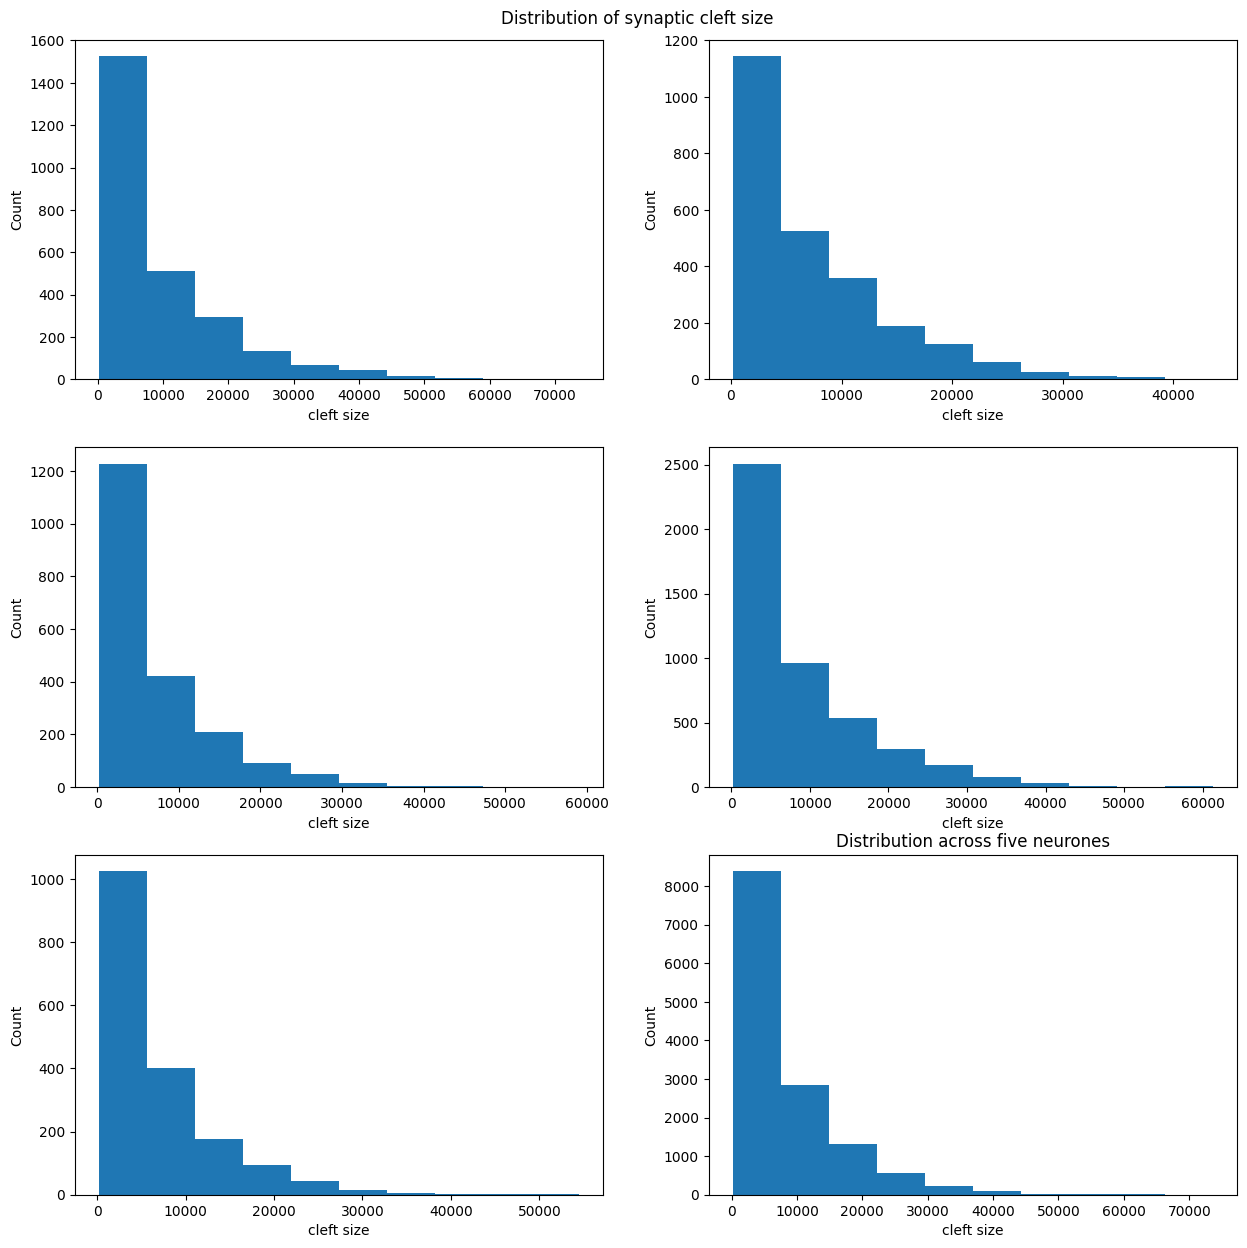

In [255]:
#Distribution of synaptic cleft sizes
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of synaptic cleft size', x = 0.5, y = 0.9)
ax = axs.ravel()
ax[0].hist(fm1['size'])
ax[1].hist(fm2['size'])
ax[2].hist(fm3['size'])
ax[3].hist(fm4['size'])
ax[4].hist(fm5['size'])
ax[5].hist(list(fm1['size'])+list(fm2['size'])+list(fm3['size'])+list(fm4['size'])+list(fm5['size']))
ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('cleft size')
plt.show()

In [256]:
print(np.mean([np.std(fm1['size']),np.std(fm2['size']),np.std(fm3['size']),np.std(fm4['size']),np.std(fm5['size'])] ))

7769.432471539099


In [257]:
print(np.mean(list(fm1['size'])+list(fm2['size'])+list(fm3['size'])+list(fm4['size'])+list(fm5['size'])))

8105.597867428505


In [212]:
print(np.median(list(fm1['size'])+list(fm2['size'])+list(fm3['size'])+list(fm4['size'])+list(fm5['size'])))

5056.666666666666


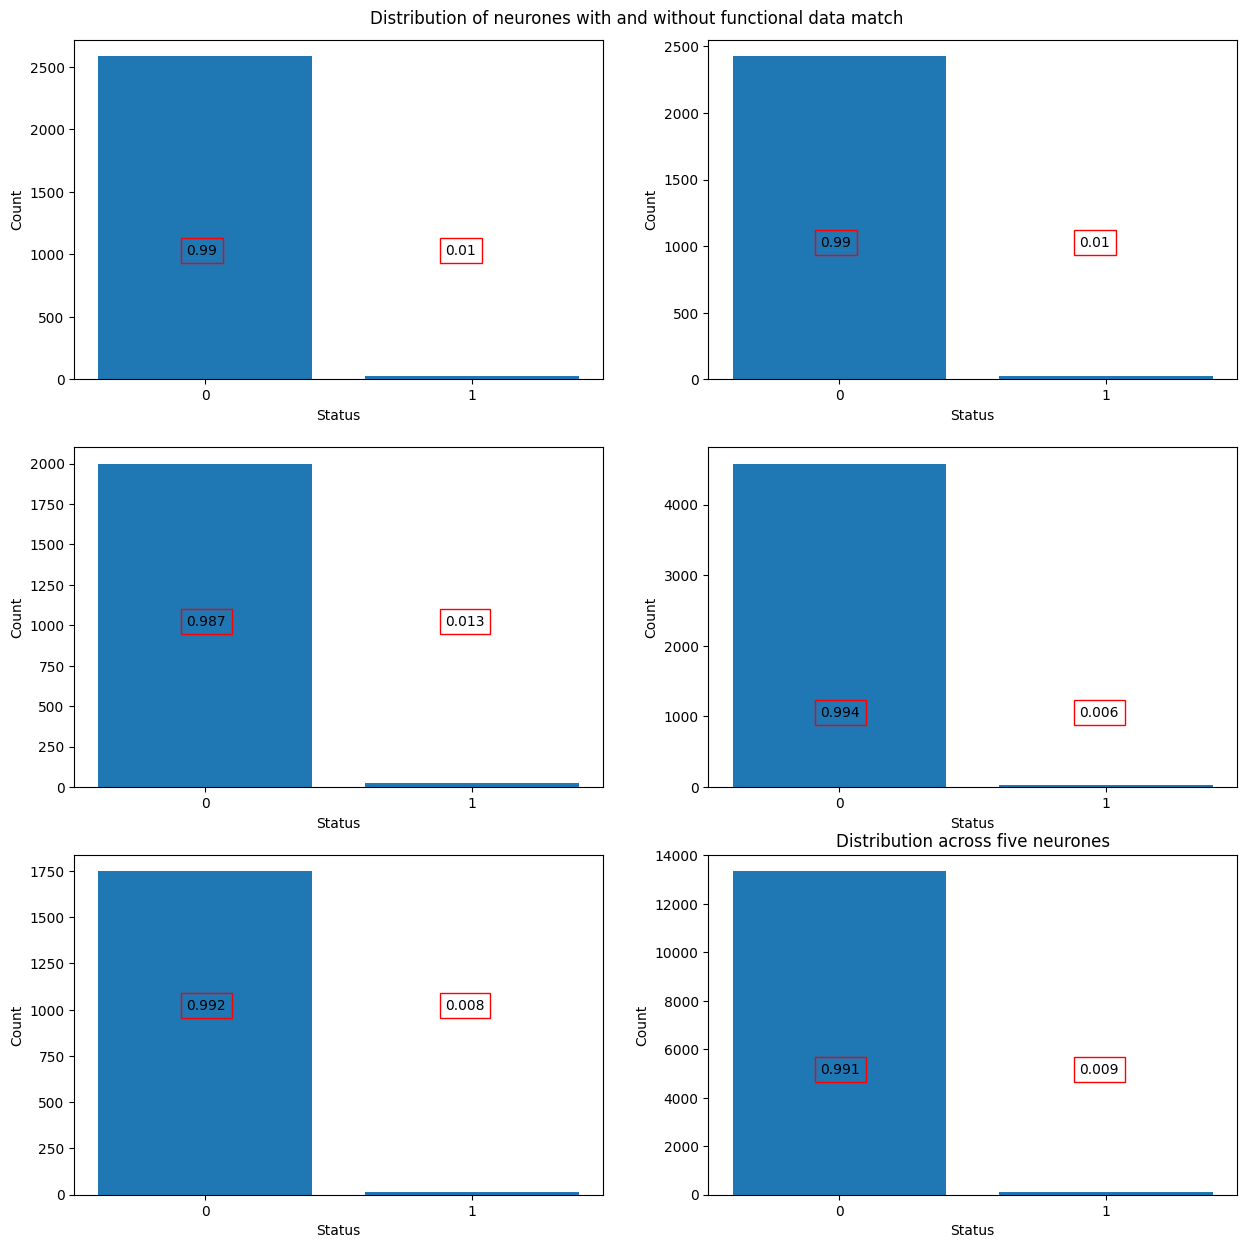

In [258]:
#Distribution of functionally matched neurones amongst pre-synaptic cells
from collections import Counter
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of neurones with and without functional data match', x = 0.5,y = 0.9)
ax = axs.ravel()
c1 = Counter(fm1['functional_data_matched'].astype('str'))
c2 = Counter(fm2['functional_data_matched'].astype('str'))
c3 = Counter(fm3['functional_data_matched'].astype('str'))
c4 = Counter(fm4['functional_data_matched'].astype('str'))
c5 = Counter(fm5['functional_data_matched'].astype('str'))
cumulative = Counter(list(fm1['functional_data_matched'].astype('str'))+list(fm2['functional_data_matched'].astype('str'))+list(fm3['functional_data_matched'].astype('str'))+list(fm4['functional_data_matched'].astype('str'))+list(fm5['functional_data_matched'].astype('str')))
ax[0].bar(list(c1.keys()),list(c1.values()))
ax[0].text(-0.07,1000,round(list(c1.values())[0]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(0.9,1000,round(list(c1.values())[1]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[1].bar(list(c2.keys()),list(c2.values()))
ax[1].text(-0.07,1000,round(list(c2.values())[0]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(0.9,1000,round(list(c2.values())[1]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[2].bar(list(c3.keys()),list(c3.values()))
ax[2].text(-0.07,1000,round(list(c3.values())[0]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(0.9,1000,round(list(c3.values())[1]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[3].bar(list(c4.keys()),list(c4.values()))
ax[3].text(-0.07,1000,round(list(c4.values())[0]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(0.9,1000,round(list(c4.values())[1]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[4].bar(list(c5.keys()),list(c5.values()))
ax[4].text(-0.07,1000,round(list(c5.values())[0]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(0.9,1000,round(list(c5.values())[1]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].bar(list(cumulative.keys()), list(cumulative.values()))
ax[5].text(-0.07,5000,round(list(cumulative.values())[0]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(0.9,5000,round(list(cumulative.values())[1]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Status')
plt.show()

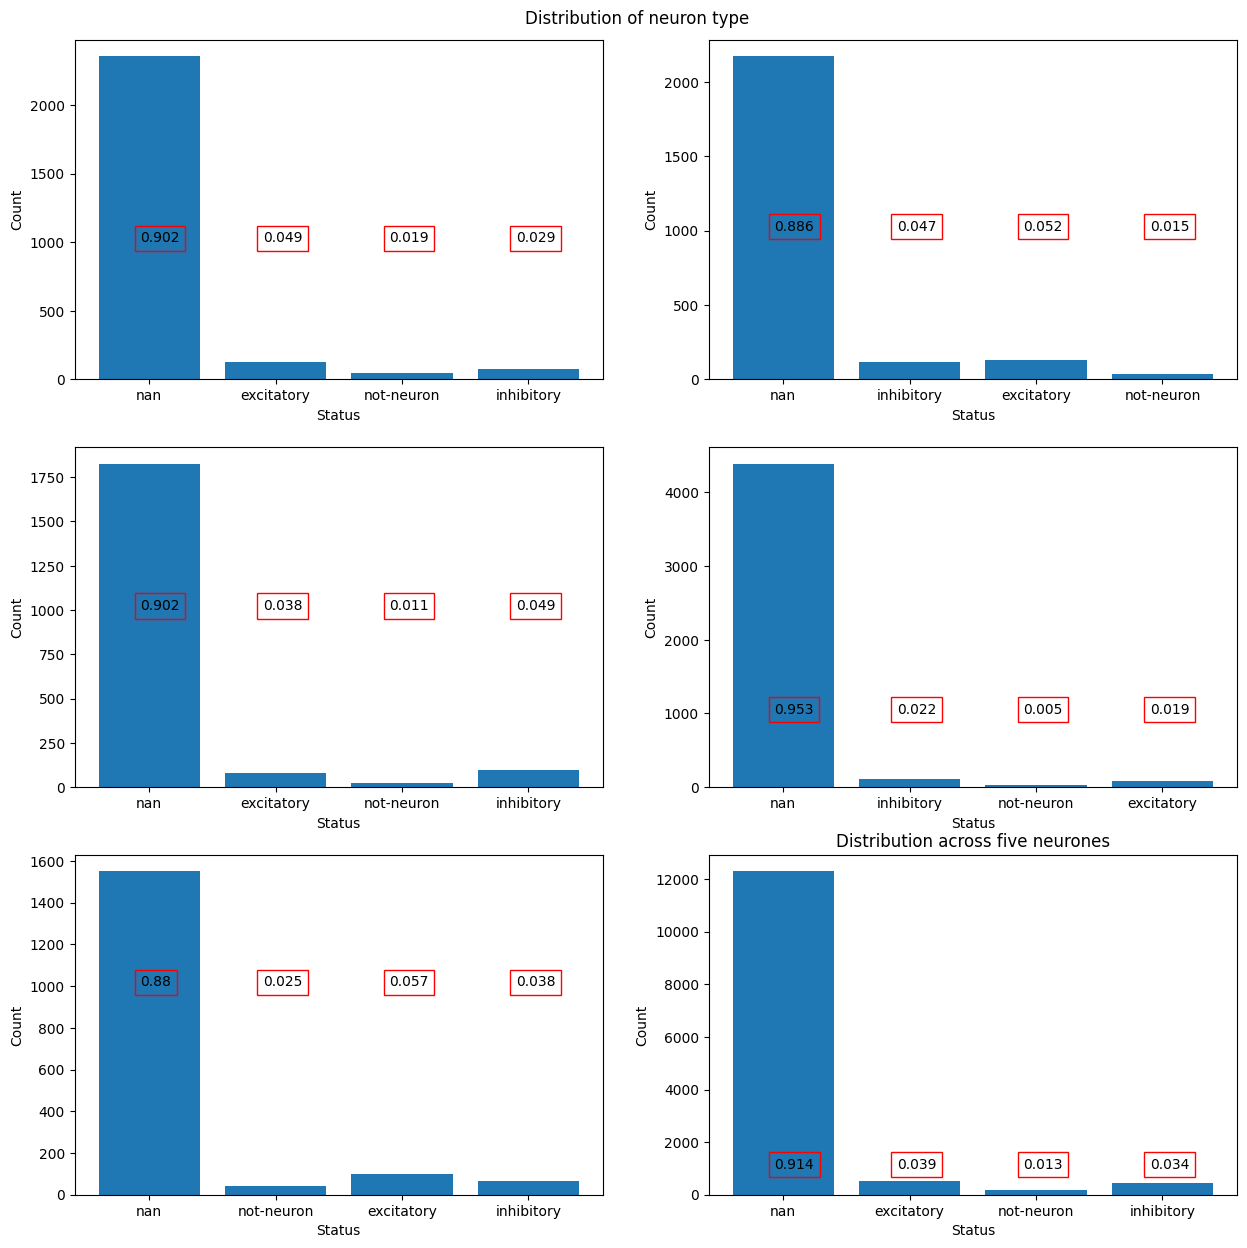

In [271]:
#Distribution of excitatory and inhibitory neurones
from collections import Counter
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of neuron type', x = 0.5,y = 0.9)
ax = axs.ravel()
c1 = Counter(fm1['neuron_type'].astype('str'))
c2 = Counter(fm2['neuron_type'].astype('str'))
c3 = Counter(fm3['neuron_type'].astype('str'))
c4 = Counter(fm4['neuron_type'].astype('str'))
c5 = Counter(fm5['neuron_type'].astype('str'))
cumulative = Counter(list(fm1['neuron_type'].astype('str'))+list(fm2['neuron_type'].astype('str'))+list(fm3['neuron_type'].astype('str'))+list(fm4['neuron_type'].astype('str'))+list(fm5['neuron_type'].astype('str')))
ax[0].bar(list(c1.keys()),list(c1.values()))
ax[0].text(-0.07,1000,round(list(c1.values())[0]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(0.9,1000,round(list(c1.values())[1]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(1.9,1000,round(list(c1.values())[2]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(2.9,1000,round(list(c1.values())[3]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[1].bar(list(c2.keys()),list(c2.values()))
ax[1].text(-0.07,1000,round(list(c2.values())[0]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(0.9,1000,round(list(c2.values())[1]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(1.9,1000,round(list(c2.values())[2]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(2.9,1000,round(list(c2.values())[3]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[2].bar(list(c3.keys()),list(c3.values()))
ax[2].text(-0.07,1000,round(list(c3.values())[0]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(0.9,1000,round(list(c3.values())[1]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(1.9,1000,round(list(c3.values())[2]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(2.9,1000,round(list(c3.values())[3]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[3].bar(list(c4.keys()),list(c4.values()))
ax[3].text(-0.07,1000,round(list(c4.values())[0]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(0.9,1000,round(list(c4.values())[1]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(1.9,1000,round(list(c4.values())[2]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(2.9,1000,round(list(c4.values())[3]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[4].bar(list(c5.keys()),list(c5.values()))
ax[4].text(-0.07,1000,round(list(c5.values())[0]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(0.9,1000,round(list(c5.values())[1]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(1.9,1000,round(list(c5.values())[2]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(2.9,1000,round(list(c5.values())[3]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].bar(list(cumulative.keys()), list(cumulative.values()))
ax[5].text(-0.07,1000,round(list(cumulative.values())[0]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(0.9,1000,round(list(cumulative.values())[1]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(1.9,1000,round(list(cumulative.values())[2]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(2.9,1000,round(list(cumulative.values())[3]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Status')
plt.show()

## Post synaptic neurones that have NOT been fully proof read

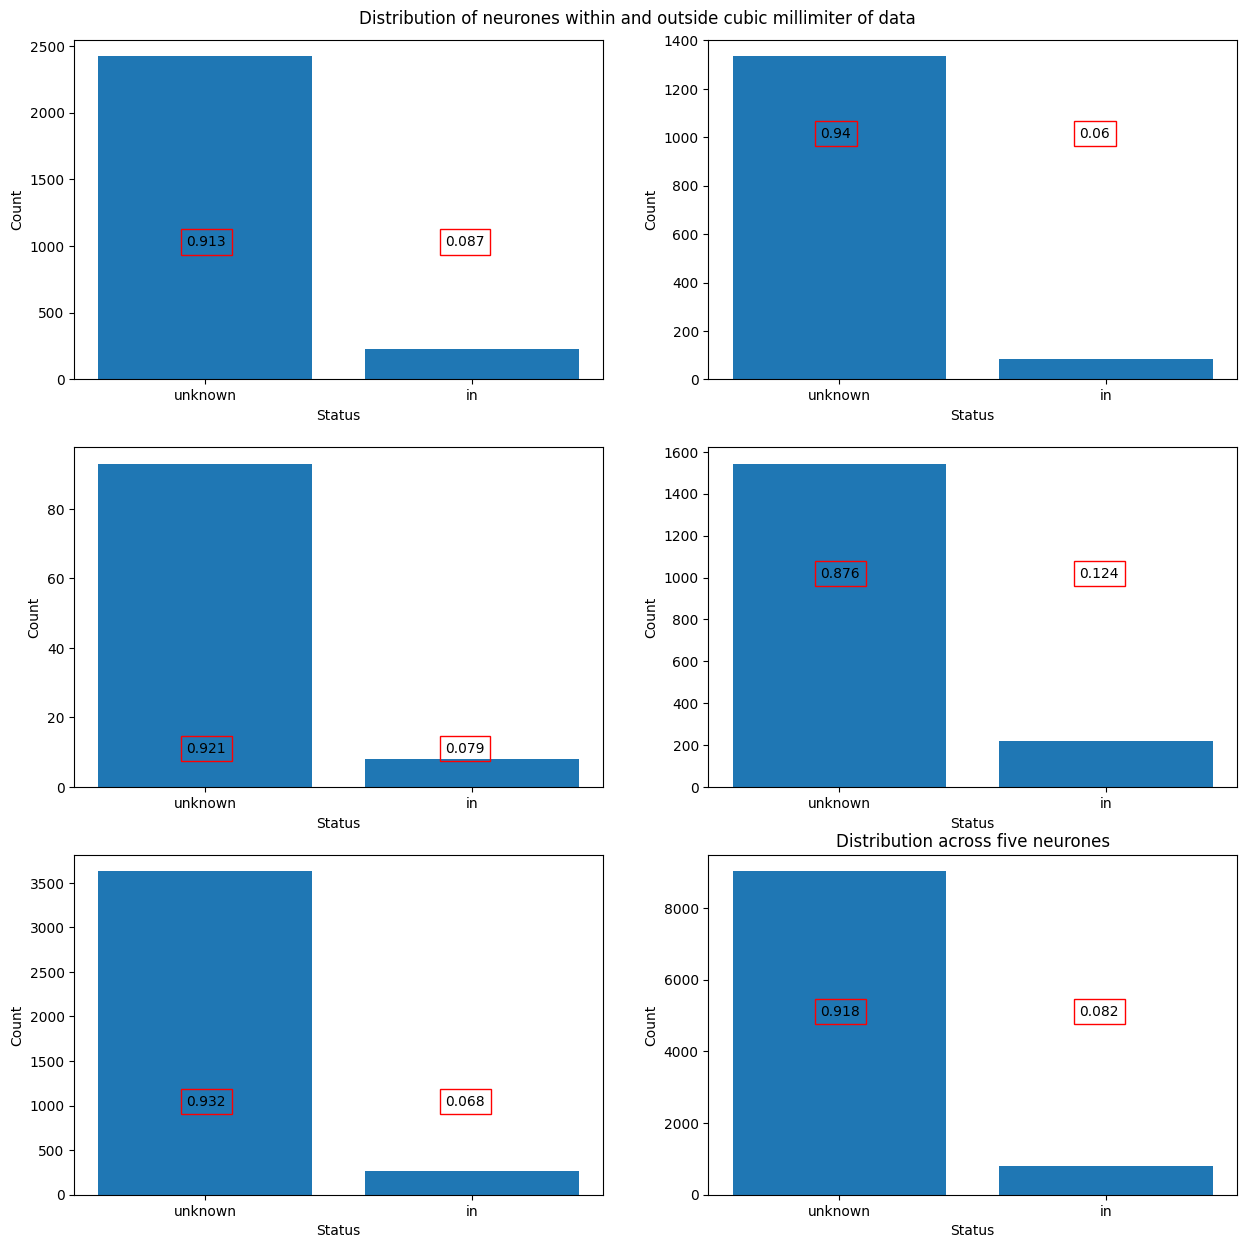

In [260]:
#Describing neurones that are within and outside the cubic millimiter of data
from collections import Counter
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of neurones within and outside cubic millimiter of data', x = 0.5,y = 0.9)
ax = axs.ravel()
c1 = Counter(nfm1['in_mmcube'].astype('str'))
c2 = Counter(nfm2['in_mmcube'].astype('str'))
c3 = Counter(nfm3['in_mmcube'].astype('str'))
c4 = Counter(nfm4['in_mmcube'].astype('str'))
c5 = Counter(nfm5['in_mmcube'].astype('str'))
cumulative = Counter(list(nfm1['in_mmcube'].astype('str'))+list(nfm2['in_mmcube'].astype('str'))+list(nfm3['in_mmcube'].astype('str'))+list(nfm4['in_mmcube'].astype('str'))+list(nfm5['in_mmcube'].astype('str')))
ax[0].bar(list(c1.keys()),list(c1.values()))
ax[0].text(-0.07,1000,round(list(c1.values())[0]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(0.9,1000,round(list(c1.values())[1]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[1].bar(list(c2.keys()),list(c2.values()))
ax[1].text(-0.07,1000,round(list(c2.values())[0]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(0.9,1000,round(list(c2.values())[1]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[2].bar(list(c3.keys()),list(c3.values()))
ax[2].text(-0.07,10,round(list(c3.values())[0]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(0.9,10,round(list(c3.values())[1]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[3].bar(list(c4.keys()),list(c4.values()))
ax[3].text(-0.07,1000,round(list(c4.values())[0]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(0.9,1000,round(list(c4.values())[1]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[4].bar(list(c5.keys()),list(c5.values()))
ax[4].text(-0.07,1000,round(list(c5.values())[0]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(0.9,1000,round(list(c5.values())[1]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].bar(list(cumulative.keys()), list(cumulative.values()))
ax[5].text(-0.07,5000,round(list(cumulative.values())[0]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(0.9,5000,round(list(cumulative.values())[1]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Status')
plt.show()

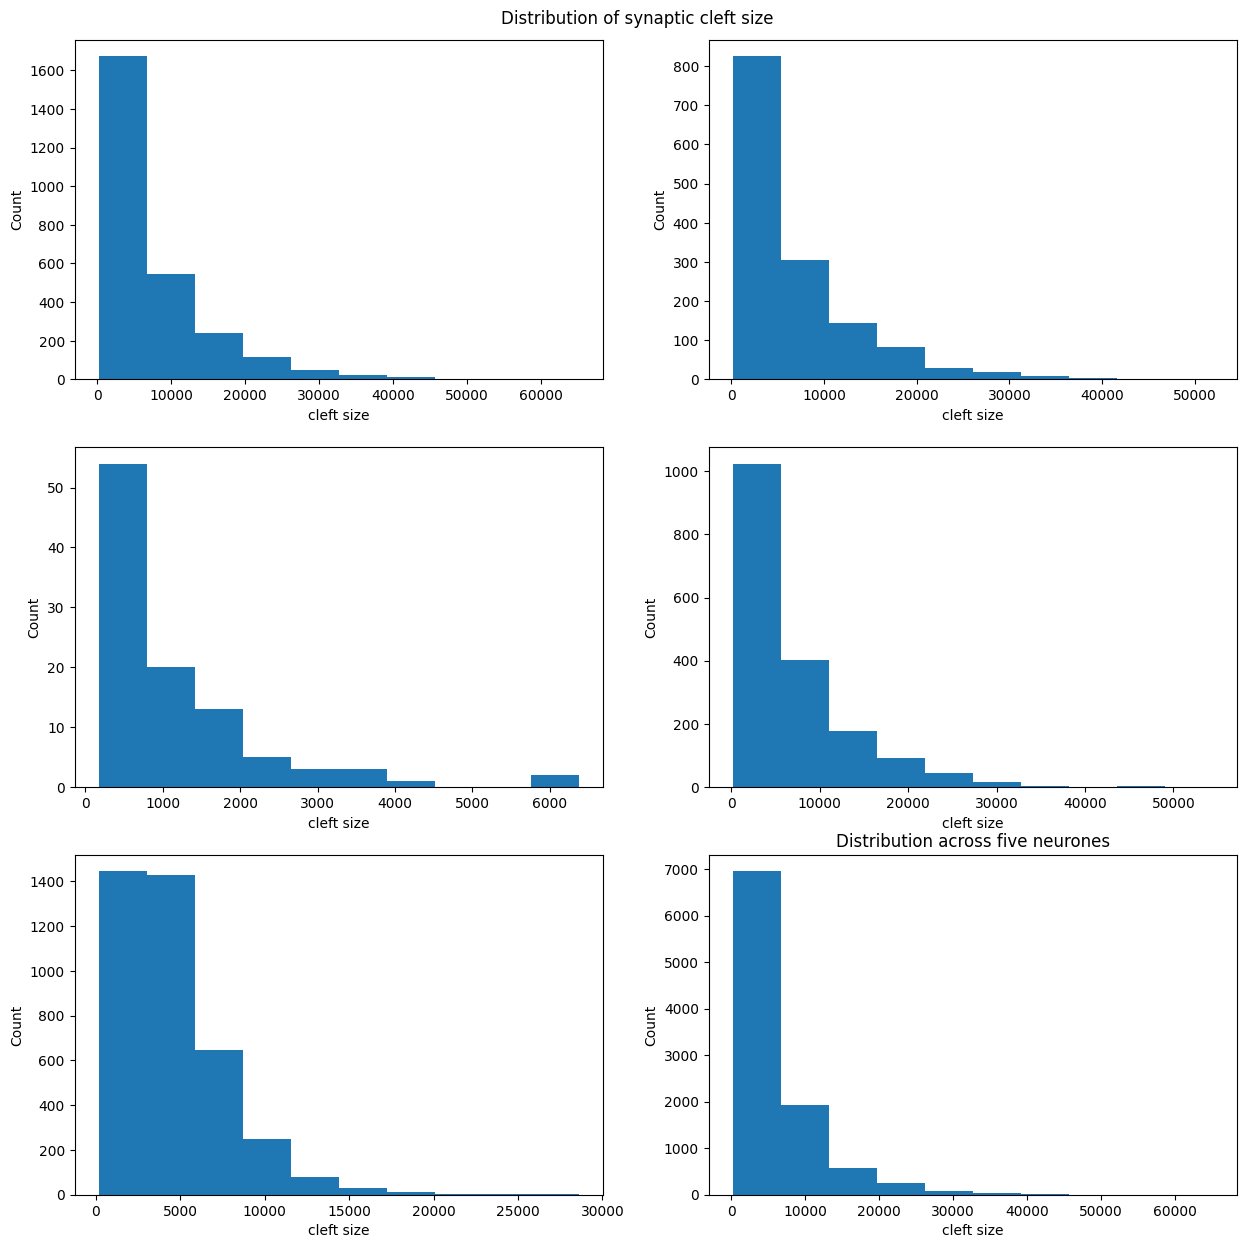

In [261]:
#Distribution of synaptic cleft sizes
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of synaptic cleft size', x = 0.5, y = 0.9)
ax = axs.ravel()
ax[0].hist(nfm1['size'])
ax[1].hist(nfm2['size'])
ax[2].hist(nfm3['size'])
ax[3].hist(nfm4['size'])
ax[4].hist(nfm5['size'])
ax[5].hist(list(nfm1['size'])+list(nfm2['size'])+list(nfm3['size'])+list(nfm4['size'])+list(nfm5['size']))
ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('cleft size')
plt.show()

In [131]:
print(np.mean([np.std(nfm1['size']),np.std(nfm2['size']),np.std(nfm3['size']),np.std(nfm4['size']),np.std(nfm5['size'])] ))

4971.695660091879


In [211]:
print(np.mean(list(nfm1['size'])+list(nfm2['size'])+list(nfm3['size'])+list(nfm4['size'])+list(nfm5['size'])))

5915.651411250537


In [213]:
print(np.median(list(nfm1['size'])+list(nfm2['size'])+list(nfm3['size'])+list(nfm4['size'])+list(nfm5['size'])))

4161.0


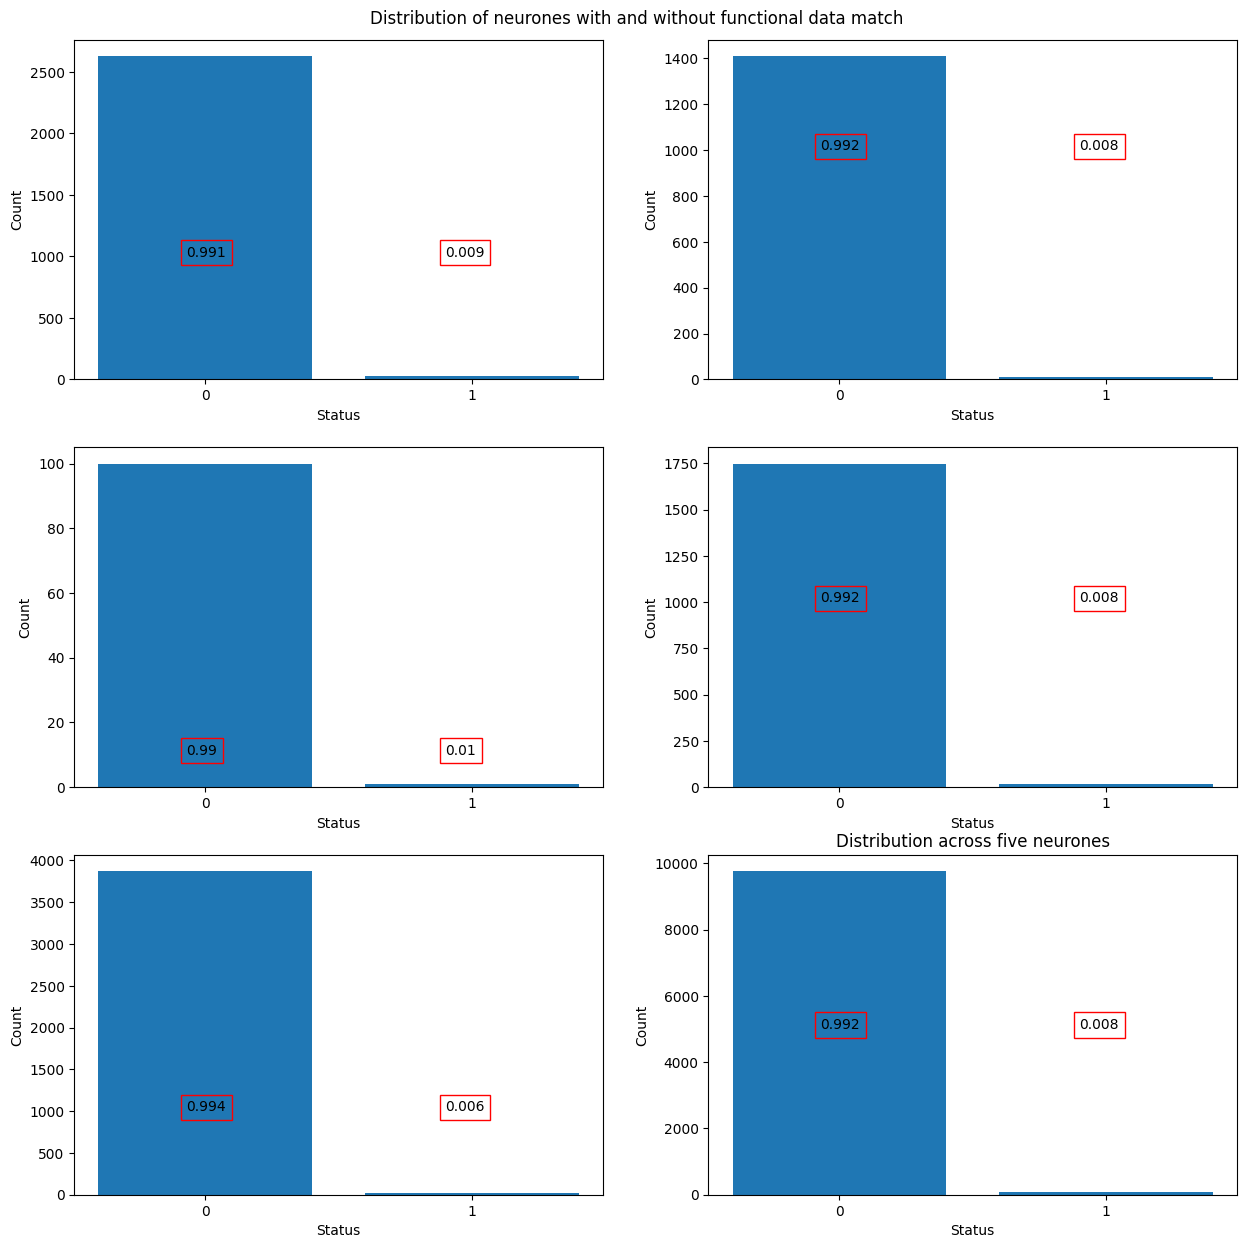

In [262]:
#Distribution of functionally matched neurones amongst pre-synaptic cells
from collections import Counter
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of neurones with and without functional data match', x = 0.5,y = 0.9)
ax = axs.ravel()
c1 = Counter(nfm1['functional_data_matched'].astype('str'))
c2 = Counter(nfm2['functional_data_matched'].astype('str'))
c3 = Counter(nfm3['functional_data_matched'].astype('str'))
c4 = Counter(nfm4['functional_data_matched'].astype('str'))
c5 = Counter(nfm5['functional_data_matched'].astype('str'))
cumulative = Counter(list(nfm1['functional_data_matched'].astype('str'))+list(nfm2['functional_data_matched'].astype('str'))+list(nfm3['functional_data_matched'].astype('str'))+list(nfm4['functional_data_matched'].astype('str'))+list(nfm5['functional_data_matched'].astype('str')))
ax[0].bar(list(c1.keys()),list(c1.values()))
ax[0].text(-0.07,1000,round(list(c1.values())[0]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(0.9,1000,round(list(c1.values())[1]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[1].bar(list(c2.keys()),list(c2.values()))
ax[1].text(-0.07,1000,round(list(c2.values())[0]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(0.9,1000,round(list(c2.values())[1]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[2].bar(list(c3.keys()),list(c3.values()))
ax[2].text(-0.07,10,round(list(c3.values())[0]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(0.9,10,round(list(c3.values())[1]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[3].bar(list(c4.keys()),list(c4.values()))
ax[3].text(-0.07,1000,round(list(c4.values())[0]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(0.9,1000,round(list(c4.values())[1]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[4].bar(list(c5.keys()),list(c5.values()))
ax[4].text(-0.07,1000,round(list(c5.values())[0]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(0.9,1000,round(list(c5.values())[1]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].bar(list(cumulative.keys()), list(cumulative.values()))
ax[5].text(-0.07,5000,round(list(cumulative.values())[0]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(0.9,5000,round(list(cumulative.values())[1]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Status')
plt.show()

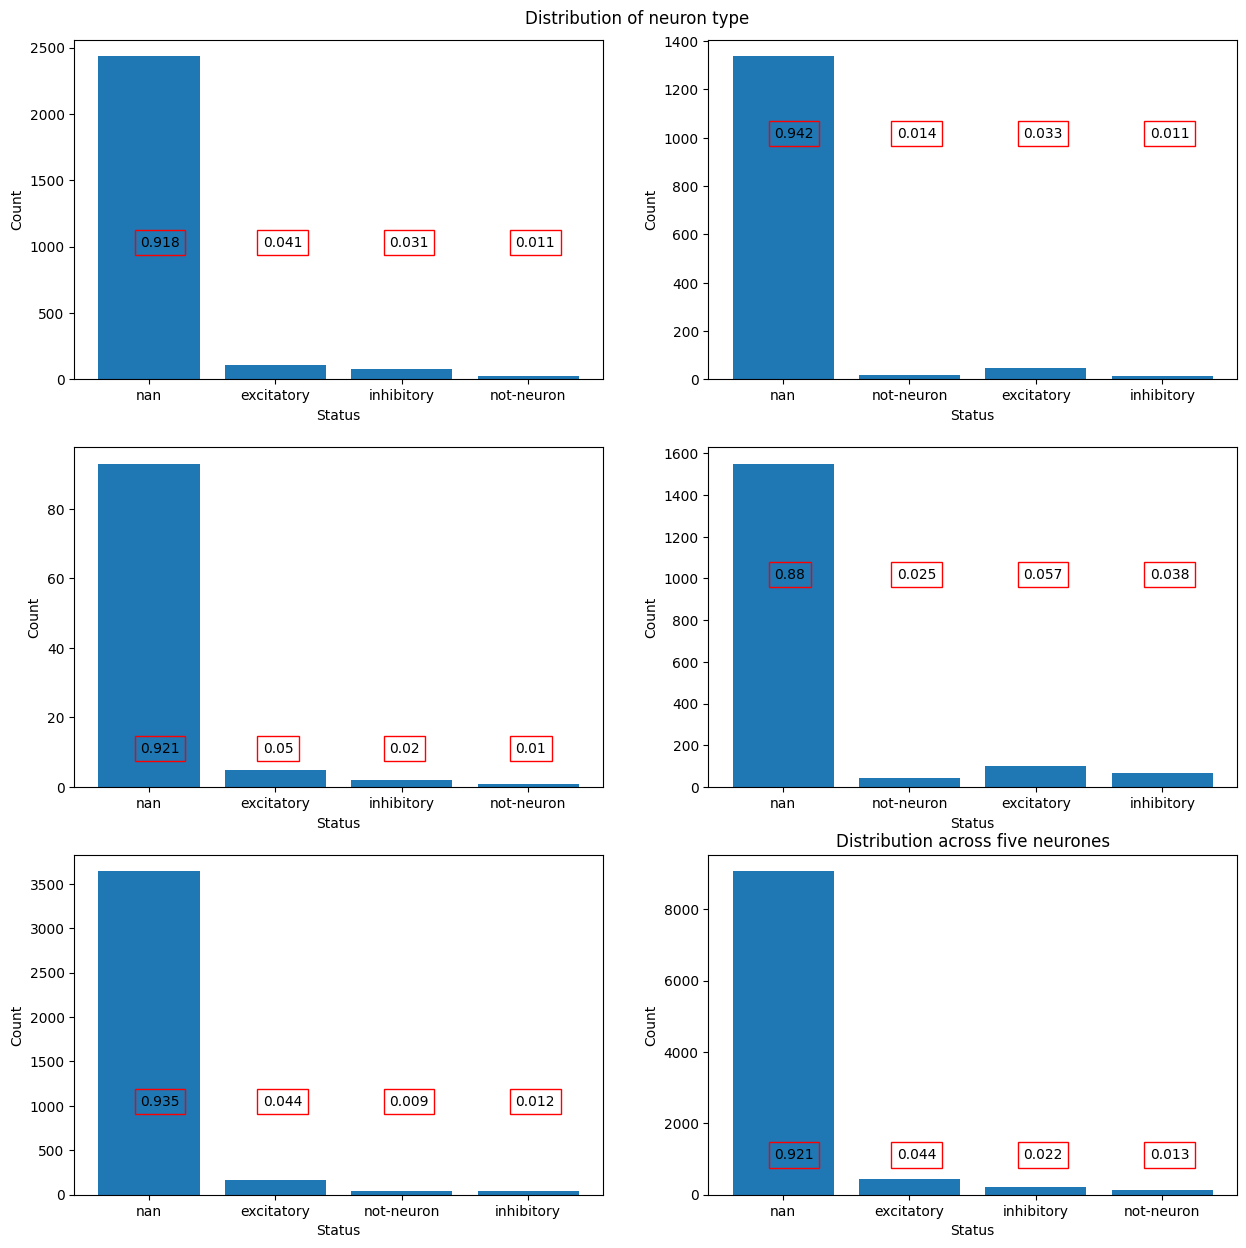

In [272]:
#Distribution of excitatory and inhibitory neurones
from collections import Counter
fig, axs = plt.subplots(3,2, figsize = (15, 15))
fig.suptitle('Distribution of neuron type', x = 0.5,y = 0.9)
ax = axs.ravel()
c1 = Counter(nfm1['neuron_type'].astype('str'))
c2 = Counter(nfm2['neuron_type'].astype('str'))
c3 = Counter(nfm3['neuron_type'].astype('str'))
c4 = Counter(nfm4['neuron_type'].astype('str'))
c5 = Counter(nfm5['neuron_type'].astype('str'))
cumulative = Counter(list(nfm1['neuron_type'].astype('str'))+list(nfm2['neuron_type'].astype('str'))+list(nfm3['neuron_type'].astype('str'))+list(nfm4['neuron_type'].astype('str'))+list(nfm5['neuron_type'].astype('str')))
ax[0].bar(list(c1.keys()),list(c1.values()))
ax[0].text(-0.07,1000,round(list(c1.values())[0]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(0.9,1000,round(list(c1.values())[1]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(1.9,1000,round(list(c1.values())[2]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[0].text(2.9,1000,round(list(c1.values())[3]/sum(list(c1.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[1].bar(list(c2.keys()),list(c2.values()))
ax[1].text(-0.07,1000,round(list(c2.values())[0]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(0.9,1000,round(list(c2.values())[1]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(1.9,1000,round(list(c2.values())[2]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[1].text(2.9,1000,round(list(c2.values())[3]/sum(list(c2.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[2].bar(list(c3.keys()),list(c3.values()))
ax[2].text(-0.07,10,round(list(c3.values())[0]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(0.9,10,round(list(c3.values())[1]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(1.9,10,round(list(c3.values())[2]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[2].text(2.9,10,round(list(c3.values())[3]/sum(list(c3.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[3].bar(list(c4.keys()),list(c4.values()))
ax[3].text(-0.07,1000,round(list(c4.values())[0]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(0.9,1000,round(list(c4.values())[1]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(1.9,1000,round(list(c4.values())[2]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[3].text(2.9,1000,round(list(c4.values())[3]/sum(list(c4.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[4].bar(list(c5.keys()),list(c5.values()))
ax[4].text(-0.07,1000,round(list(c5.values())[0]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(0.9,1000,round(list(c5.values())[1]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(1.9,1000,round(list(c5.values())[2]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[4].text(2.9,1000,round(list(c5.values())[3]/sum(list(c5.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].bar(list(cumulative.keys()), list(cumulative.values()))
ax[5].text(-0.07,1000,round(list(cumulative.values())[0]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(0.9,1000,round(list(cumulative.values())[1]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(1.9,1000,round(list(cumulative.values())[2]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))
ax[5].text(2.9,1000,round(list(cumulative.values())[3]/sum(list(cumulative.values())),3),bbox = dict(facecolor='none', edgecolor='red'))

ax[5].set_title('Distribution across five neurones')
for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Status')
plt.show()

## General descriptives

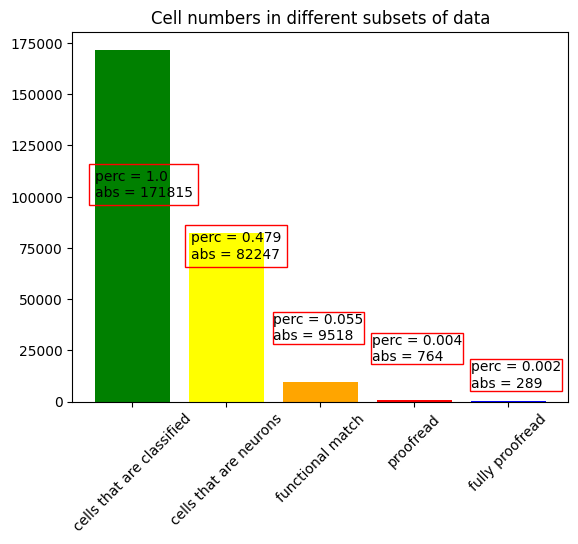

In [11]:
#Distribution across the datasets
fp = full_proof[(full_proof['status_dendrite'] == 'extended')& (full_proof['status_axon'] == 'extended')].shape[0]
n = svm[(svm['pt_root_id']!=0) & (svm['cell_type']=='neuron')].shape[0]
labels = ['cells that are classified','cells that are neurons', 'functional match', 'proofread', 'fully proofread']
values = [svm.shape[0], n, funct_match.shape[0], full_proof.shape[0],fp]
color = ['green', 'yellow', 'orange', 'red', 'blue']

plt.bar(labels, values, color = color)
plt.title('Cell numbers in different subsets of data')
plt.text(-0.4,100000, f'perc = {svm.shape[0]/svm.shape[0]}\nabs = {svm.shape[0]}', bbox = dict(facecolor='none', edgecolor='red'))
plt.text(0.62,70000, f'perc = {round(n/svm.shape[0], 3)}\nabs = {n}', bbox = dict(facecolor='none', edgecolor='red'))
plt.text(1.5,30000, f'perc = {round(funct_match.shape[0]/svm.shape[0],3)}\nabs = {funct_match.shape[0]}', bbox = dict(facecolor='none', edgecolor='red', pad = 0.5))
plt.text(2.55,20000, f'perc = {round(full_proof.shape[0]/svm.shape[0],3)}\nabs = {full_proof.shape[0]}', bbox = dict(facecolor='none', edgecolor='red', pad = 0.5))
plt.text(3.6,7000, f'perc = {round(fp/svm.shape[0],3)}\nabs = {fp}', bbox = dict(facecolor='none', edgecolor='red', pad = 0.5))

plt.xticks(rotation = 45)
plt.show()

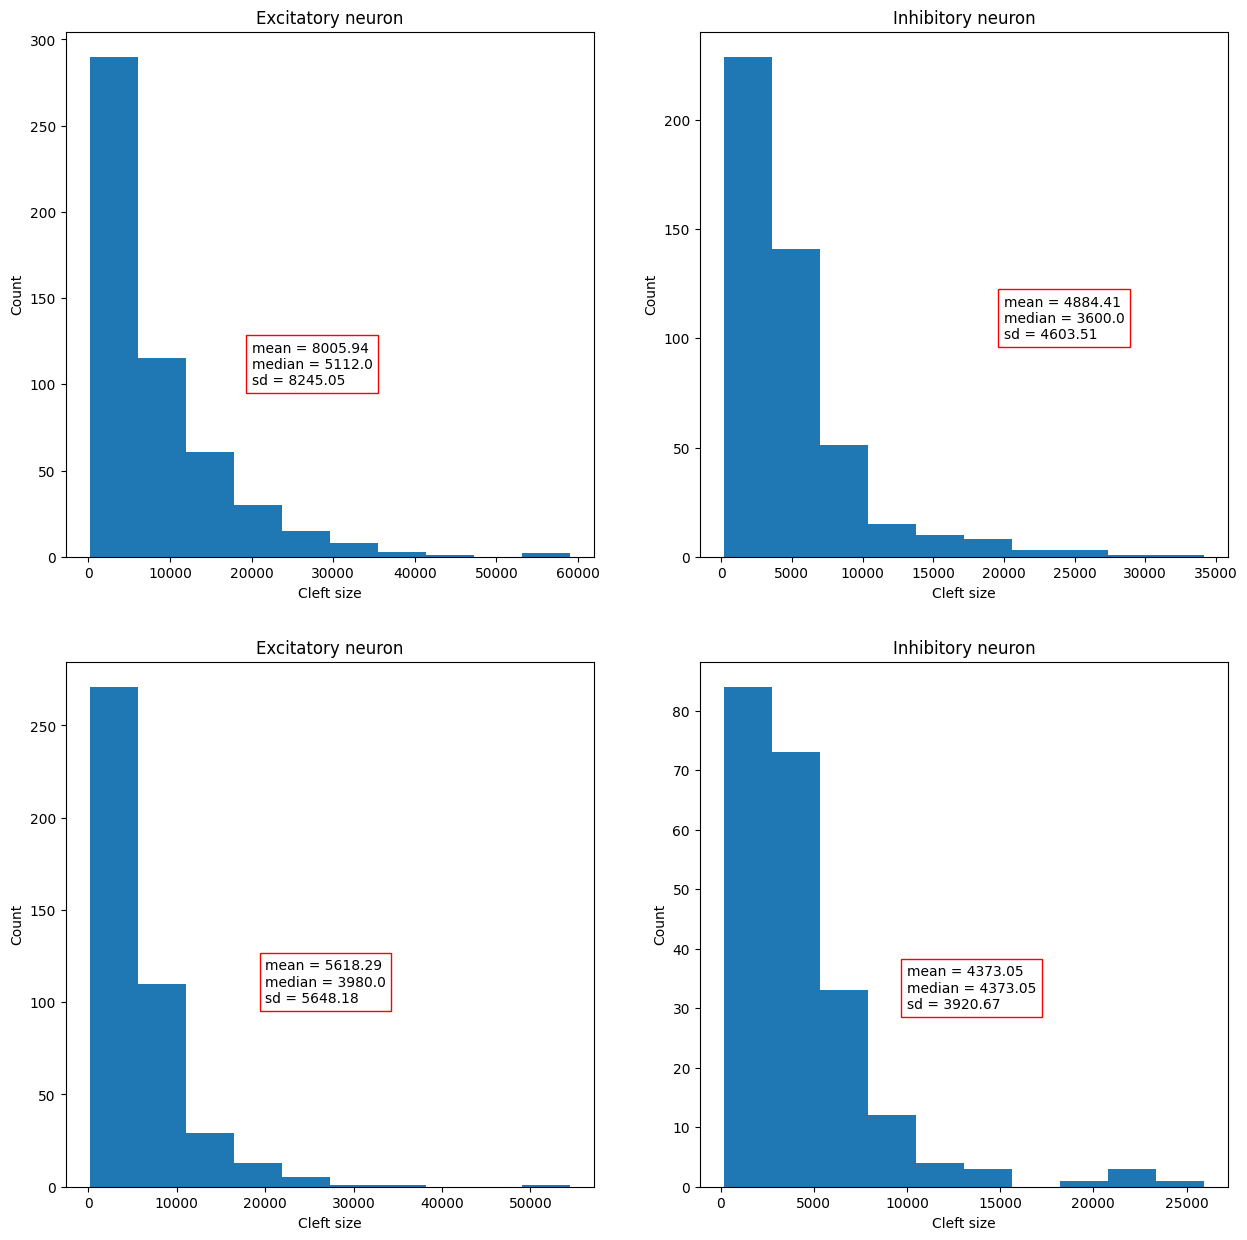

In [264]:
#Synpatic size dsitribution by neuron type
fig, axs = plt.subplots(2,2, figsize = (15,15))
ax = axs.ravel()
ax[0].hist(list(fm1[fm1['neuron_type']=='excitatory']['size'])+list(fm2[fm2['neuron_type']=='excitatory']['size'])+list(fm3[fm3['neuron_type']=='excitatory']['size'])+list(fm4[fm4['neuron_type']=='excitatory']['size'])+list(fm5[fm5['neuron_type']=='excitatory']['size']))
ax[0].text(20000,100, f"mean = {round(np.mean(list(fm1[fm1['neuron_type']=='excitatory']['size'])+list(fm2[fm2['neuron_type']=='excitatory']['size'])+list(fm3[fm3['neuron_type']=='excitatory']['size'])+list(fm4[fm4['neuron_type']=='excitatory']['size'])+list(fm5[fm5['neuron_type']=='excitatory']['size'])),2)}\nmedian = {round(np.median(list(fm1[fm1['neuron_type']=='excitatory']['size'])+list(fm2[fm2['neuron_type']=='excitatory']['size'])+list(fm3[fm3['neuron_type']=='excitatory']['size'])+list(fm4[fm4['neuron_type']=='excitatory']['size'])+list(fm5[fm5['neuron_type']=='excitatory']['size'])),2)}\nsd = {round(np.std(list(fm1[fm1['neuron_type']=='excitatory']['size'])+list(fm2[fm2['neuron_type']=='excitatory']['size'])+list(fm3[fm3['neuron_type']=='excitatory']['size'])+list(fm4[fm4['neuron_type']=='excitatory']['size'])+list(fm5[fm5['neuron_type']=='excitatory']['size'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )


ax[1].hist(list(fm1[fm1['neuron_type']=='inhibitory']['size'])+list(fm2[fm2['neuron_type']=='inhibitory']['size'])+list(fm3[fm3['neuron_type']=='inhibitory']['size'])+list(fm4[fm4['neuron_type']=='inhibitory']['size'])+list(fm5[fm5['neuron_type']=='inhibitory']['size']))
ax[1].text(20000,100, f"mean = {round(np.mean(list(fm1[fm1['neuron_type']=='inhibitory']['size'])+list(fm2[fm2['neuron_type']=='inhibitory']['size'])+list(fm3[fm3['neuron_type']=='inhibitory']['size'])+list(fm4[fm4['neuron_type']=='inhibitory']['size'])+list(fm5[fm5['neuron_type']=='inhibitory']['size'])),2)}\nmedian = {round(np.median(list(fm1[fm1['neuron_type']=='inhibitory']['size'])+list(fm2[fm2['neuron_type']=='inhibitory']['size'])+list(fm3[fm3['neuron_type']=='inhibitory']['size'])+list(fm4[fm4['neuron_type']=='inhibitory']['size'])+list(fm5[fm5['neuron_type']=='inhibitory']['size'])),2)}\nsd = {round(np.std(list(fm1[fm1['neuron_type']=='inhibitory']['size'])+list(fm2[fm2['neuron_type']=='inhibitory']['size'])+list(fm3[fm3['neuron_type']=='inhibitory']['size'])+list(fm4[fm4['neuron_type']=='inhibitory']['size'])+list(fm5[fm5['neuron_type']=='inhibitory']['size'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )


ax[2].hist(list(nfm1[nfm1['neuron_type']=='excitatory']['size'])+list(nfm2[nfm2['neuron_type']=='excitatory']['size'])+list(nfm3[nfm3['neuron_type']=='excitatory']['size'])+list(nfm4[nfm4['neuron_type']=='excitatory']['size'])+list(nfm5[nfm5['neuron_type']=='excitatory']['size']))
ax[2].text(20000,100, f"mean = {round(np.mean(list(nfm1[nfm1['neuron_type']=='excitatory']['size'])+list(nfm2[nfm2['neuron_type']=='excitatory']['size'])+list(nfm3[nfm3['neuron_type']=='excitatory']['size'])+list(nfm4[nfm4['neuron_type']=='excitatory']['size'])+list(nfm5[nfm5['neuron_type']=='excitatory']['size'])),2)}\nmedian = {round(np.median(list(nfm1[nfm1['neuron_type']=='excitatory']['size'])+list(nfm2[nfm2['neuron_type']=='excitatory']['size'])+list(nfm3[nfm3['neuron_type']=='excitatory']['size'])+list(nfm4[nfm4['neuron_type']=='excitatory']['size'])+list(nfm5[nfm5['neuron_type']=='excitatory']['size'])),2)}\nsd = {round(np.std(list(nfm1[nfm1['neuron_type']=='excitatory']['size'])+list(nfm2[nfm2['neuron_type']=='excitatory']['size'])+list(nfm3[nfm3['neuron_type']=='excitatory']['size'])+list(nfm4[nfm4['neuron_type']=='excitatory']['size'])+list(nfm5[nfm5['neuron_type']=='excitatory']['size'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )


ax[3].hist(list(nfm1[nfm1['neuron_type']=='inhibitory']['size'])+list(nfm2[nfm2['neuron_type']=='inhibitory']['size'])+list(nfm3[nfm3['neuron_type']=='inhibitory']['size'])+list(nfm4[nfm4['neuron_type']=='inhibitory']['size'])+list(nfm5[nfm5['neuron_type']=='inhibitory']['size']))
ax[3].text(10000,30, f"mean = {round(np.mean(list(nfm1[nfm1['neuron_type']=='inhibitory']['size'])+list(nfm2[nfm2['neuron_type']=='inhibitory']['size'])+list(nfm3[nfm3['neuron_type']=='inhibitory']['size'])+list(nfm4[nfm4['neuron_type']=='inhibitory']['size'])+list(nfm5[nfm5['neuron_type']=='inhibitory']['size'])),2)}\nmedian = {round(np.mean(list(nfm1[nfm1['neuron_type']=='inhibitory']['size'])+list(nfm2[nfm2['neuron_type']=='inhibitory']['size'])+list(nfm3[nfm3['neuron_type']=='inhibitory']['size'])+list(nfm4[nfm4['neuron_type']=='inhibitory']['size'])+list(nfm5[nfm5['neuron_type']=='inhibitory']['size'])),2)}\nsd = {round(np.std(list(nfm1[nfm1['neuron_type']=='inhibitory']['size'])+list(nfm2[nfm2['neuron_type']=='inhibitory']['size'])+list(nfm3[nfm3['neuron_type']=='inhibitory']['size'])+list(nfm4[nfm4['neuron_type']=='inhibitory']['size'])+list(nfm5[nfm5['neuron_type']=='inhibitory']['size'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )

for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Cleft size')
    if i==0 or i == 2:
        ax[i].set_title('Excitatory neuron')
    else:
        ax[i].set_title('Inhibitory neuron')
plt.show()

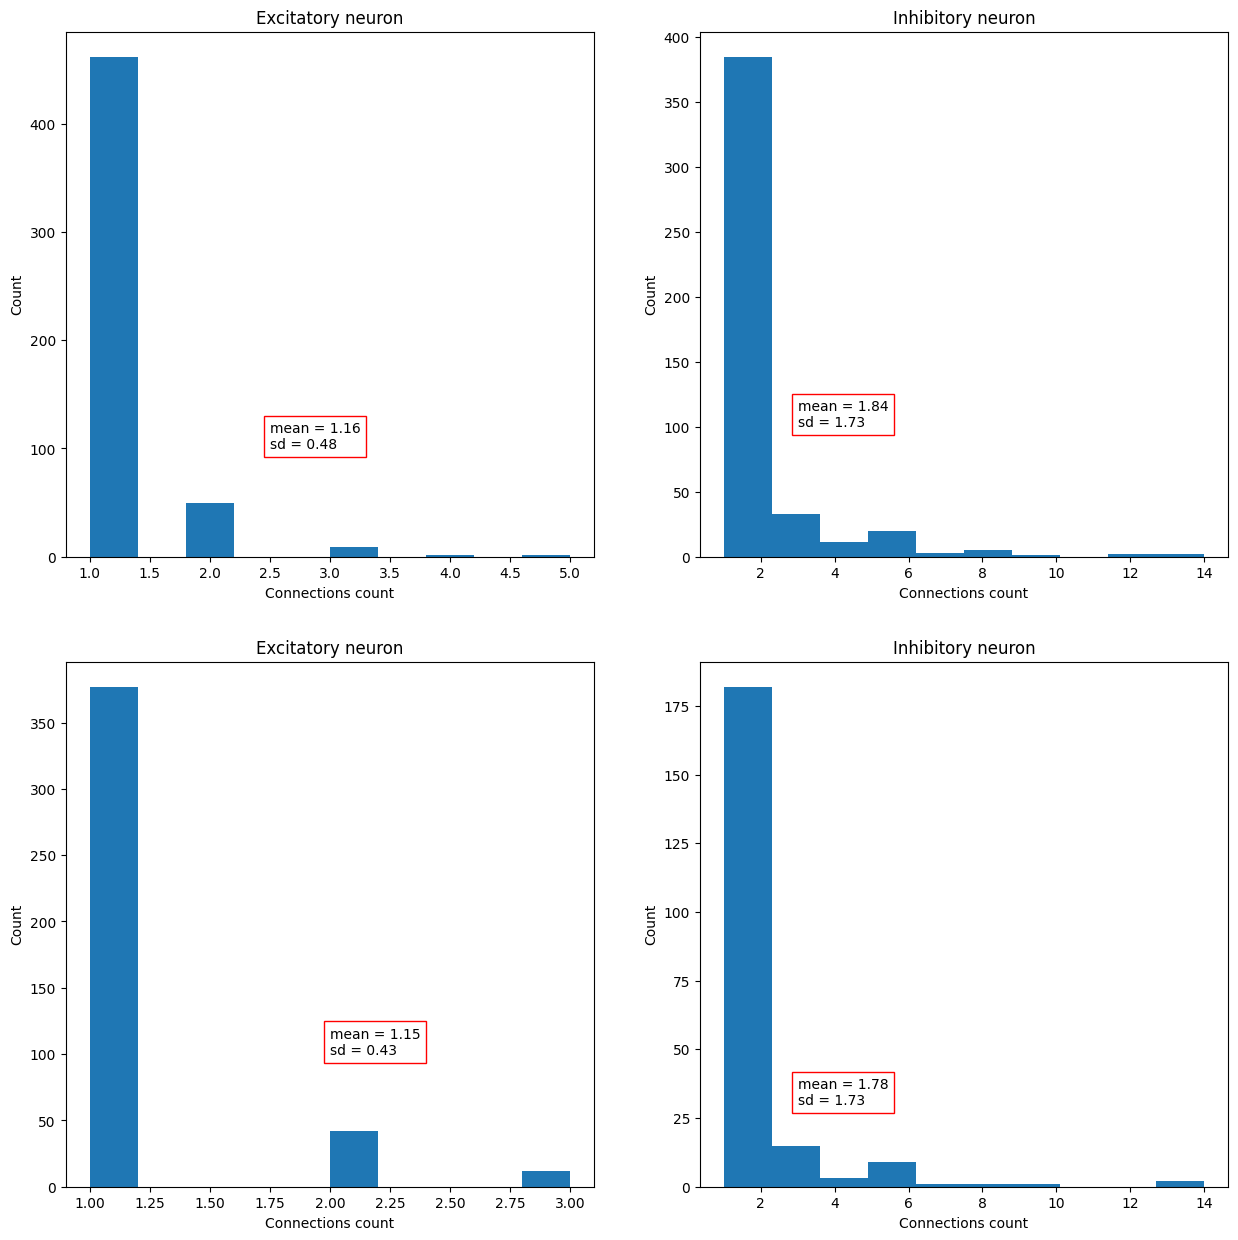

In [265]:
#Synpatic count distribution by neuron type
fig, axs = plt.subplots(2,2, figsize = (15,15))
ax = axs.ravel()
ax[0].hist(list(fm1[fm1['neuron_type']=='excitatory']['count'])+list(fm2[fm2['neuron_type']=='excitatory']['count'])+list(fm3[fm3['neuron_type']=='excitatory']['count'])+list(fm4[fm4['neuron_type']=='excitatory']['count'])+list(fm5[fm5['neuron_type']=='excitatory']['count']))
ax[0].text(2.5,100, f"mean = {round(np.mean(list(fm1[fm1['neuron_type']=='excitatory']['count'])+list(fm2[fm2['neuron_type']=='excitatory']['count'])+list(fm3[fm3['neuron_type']=='excitatory']['count'])+list(fm4[fm4['neuron_type']=='excitatory']['count'])+list(fm5[fm5['neuron_type']=='excitatory']['count'])),2)}\nsd = {round(np.std(list(fm1[fm1['neuron_type']=='excitatory']['count'])+list(fm2[fm2['neuron_type']=='excitatory']['count'])+list(fm3[fm3['neuron_type']=='excitatory']['count'])+list(fm4[fm4['neuron_type']=='excitatory']['count'])+list(fm5[fm5['neuron_type']=='excitatory']['count'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )


ax[1].hist(list(fm1[fm1['neuron_type']=='inhibitory']['count'])+list(fm2[fm2['neuron_type']=='inhibitory']['count'])+list(fm3[fm3['neuron_type']=='inhibitory']['count'])+list(fm4[fm4['neuron_type']=='inhibitory']['count'])+list(fm5[fm5['neuron_type']=='inhibitory']['count']))
ax[1].text(3,100, f"mean = {round(np.mean(list(fm1[fm1['neuron_type']=='inhibitory']['count'])+list(fm2[fm2['neuron_type']=='inhibitory']['count'])+list(fm3[fm3['neuron_type']=='inhibitory']['count'])+list(fm4[fm4['neuron_type']=='inhibitory']['count'])+list(fm5[fm5['neuron_type']=='inhibitory']['count'])),2)}\nsd = {round(np.std(list(fm1[fm1['neuron_type']=='inhibitory']['count'])+list(fm2[fm2['neuron_type']=='inhibitory']['count'])+list(fm3[fm3['neuron_type']=='inhibitory']['count'])+list(fm4[fm4['neuron_type']=='inhibitory']['count'])+list(fm5[fm5['neuron_type']=='inhibitory']['count'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )


ax[2].hist(list(nfm1[nfm1['neuron_type']=='excitatory']['count'])+list(nfm2[nfm2['neuron_type']=='excitatory']['count'])+list(nfm3[nfm3['neuron_type']=='excitatory']['count'])+list(nfm4[nfm4['neuron_type']=='excitatory']['count'])+list(nfm5[nfm5['neuron_type']=='excitatory']['count']))
ax[2].text(2,100, f"mean = {round(np.mean(list(nfm1[nfm1['neuron_type']=='excitatory']['count'])+list(nfm2[nfm2['neuron_type']=='excitatory']['count'])+list(nfm3[nfm3['neuron_type']=='excitatory']['count'])+list(nfm4[nfm4['neuron_type']=='excitatory']['count'])+list(nfm5[nfm5['neuron_type']=='excitatory']['count'])),2)}\nsd = {round(np.std(list(nfm1[nfm1['neuron_type']=='excitatory']['count'])+list(nfm2[nfm2['neuron_type']=='excitatory']['count'])+list(nfm3[nfm3['neuron_type']=='excitatory']['count'])+list(nfm4[nfm4['neuron_type']=='excitatory']['count'])+list(nfm5[nfm5['neuron_type']=='excitatory']['count'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )


ax[3].hist(list(nfm1[nfm1['neuron_type']=='inhibitory']['count'])+list(nfm2[nfm2['neuron_type']=='inhibitory']['count'])+list(nfm3[nfm3['neuron_type']=='inhibitory']['count'])+list(nfm4[nfm4['neuron_type']=='inhibitory']['count'])+list(nfm5[nfm5['neuron_type']=='inhibitory']['count']))
ax[3].text(3,30, f"mean = {round(np.mean(list(nfm1[nfm1['neuron_type']=='inhibitory']['count'])+list(nfm2[nfm2['neuron_type']=='inhibitory']['count'])+list(nfm3[nfm3['neuron_type']=='inhibitory']['count'])+list(nfm4[nfm4['neuron_type']=='inhibitory']['count'])+list(nfm5[nfm5['neuron_type']=='inhibitory']['count'])),2)}\nsd = {round(np.std(list(nfm1[nfm1['neuron_type']=='inhibitory']['count'])+list(nfm2[nfm2['neuron_type']=='inhibitory']['count'])+list(nfm3[nfm3['neuron_type']=='inhibitory']['count'])+list(nfm4[nfm4['neuron_type']=='inhibitory']['count'])+list(nfm5[nfm5['neuron_type']=='inhibitory']['count'])),2)}", bbox =dict(facecolor='none', edgecolor='red') )

for i in range(len(ax)):
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel('Connections count')
    if i==0 or i == 2:
        ax[i].set_title('Excitatory neuron')
    else:
        ax[i].set_title('Inhibitory neuron')
plt.show()

## Exploring the pre synaptic cells of the fully proofread cells

In [292]:
ffp = full_proof[full_proof['status_dendrite'] == 'extended']#)& (full_proof['status_axon'] == 'extended')]
ffp1 = ffp.iloc[:318, :]
ffp2 = ffp.iloc[318:, :]

In [293]:
syn_df1 = client.materialize.query_table('synapses_pni_2',
                                        filter_in_dict={'post_pt_root_id': ffp1.pt_root_id.values})
syn_df2 = client.materialize.query_table('synapses_pni_2',
                                        filter_in_dict={'post_pt_root_id': ffp2.pt_root_id.values})

ConnectionError: HTTPSConnectionPool(host='minnie.microns-daf.com', port=443): Max retries exceeded with url: /materialize/api/v2/datastack/minnie65_public_v343/version/343/table/synapses_pni_2/query?return_pyarrow=True&split_positions=True (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x12f051f00>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [277]:
diff = set(syn_df1['pre_pt_root_id']).difference(set(svm['pt_root_id']))
diff2 = set(syn_df2['pre_pt_root_id']).difference(set(svm['pt_root_id']))
intersec = set(syn_df1['pre_pt_root_id']).intersection(set(svm['pt_root_id']))
intersec2 = set(syn_df2['pre_pt_root_id']).intersection(set(svm['pt_root_id']))
tot_unknown = diff.union(diff2)
tot_known = intersec.union(intersec2)
tot = set(syn_df1['pre_pt_root_id']).union(set(syn_df2['pre_pt_root_id']))

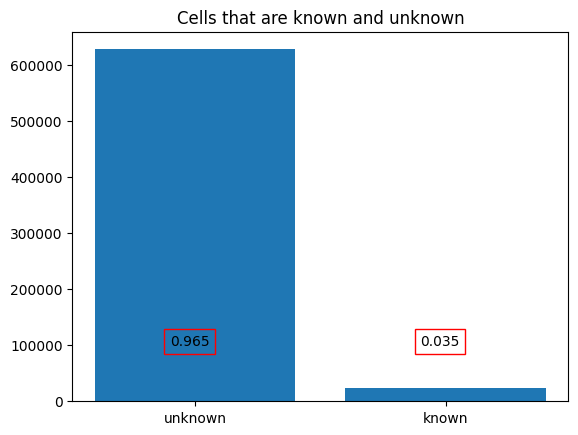

In [286]:
from collections import Counter
incmm = ['unknown']*len(tot_unknown)+['known']*len(tot_known)
c = Counter(incmm)
plt.bar(c.keys(), c.values())
plt.text(-0.1, 100000, round(len(tot_unknown)/len(tot), 3), bbox = dict(facecolor='none', edgecolor='red'))
plt.text(0.9, 100000, round(len(tot_known)/len(tot), 3), bbox = dict(facecolor='none', edgecolor='red'))
plt.title('Cells that are known and unknown')
plt.show()

In [291]:
full_proof[full_proof['status_dendrite'] == 'extended'].shape

(636, 8)